<h2>Assignment 1.2</h2>

This code partly contains visualizations for Assignment 1.3 (RFM 3D-Scatter Plot)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [ ]:
transactions = pd.read_csv('Comfy_Data/Transactions.csv', sep = ';') 

In [109]:
clients = pd.read_csv('Comfy_Data/Client_information.csv', sep = ';')

In [136]:
# Convert 'Sale_Return', 'Client_id', 'Credit', and 'SKU_id', 'Revenue', 'Quantity'  to numeric types
transactions['Revenue'] = pd.to_numeric(transactions['Revenue'], errors='coerce')
transactions['Quantity'] = pd.to_numeric(transactions['Quantity'], errors='coerce')
transactions['Sale_Return'] = pd.to_numeric(transactions['Sale_Return'], errors='coerce')
transactions['Client_id'] = pd.to_numeric(transactions['Client_id'], errors='coerce')
transactions['Credit'] = pd.to_numeric(transactions['Credit'], errors='coerce')
transactions['SKU_id'] = pd.to_numeric(transactions['SKU_id'], errors='coerce')

#Convert to date time 
transactions['Date'] = pd.to_datetime(transactions['Date'], errors='coerce')

clients['Age'] = pd.to_numeric(clients['Age'], errors='coerce')
clients['Client_id'] = pd.to_numeric(clients['Client_id'], errors='coerce')

In [137]:

total_clients = len(clients['Client_id'].unique())
print(f'Total number of clients: {total_clients}')


Total number of clients: 411131


In [138]:
average_age = clients['Age'].mean()
print(f'Average age of clients: {average_age}')

# Count unique values in the 'Gender' column
gender_counts = clients['Gender'].value_counts()

# Print the counts
print("Count of each unique gender value in the 'Gender' column:")
print(gender_counts)


Average age of clients: 39.73635830927049
Count of each unique gender value in the 'Gender' column:
-         386369
female     13073
male       11689
Name: Gender, dtype: int64



Outlier Statistics:
Minimum outlier value: -288000.0
Median outlier value: 13899.0
Maximum outlier value: 539909999.0
Mean outlier value: 22629.387147654423
Standard deviation of outliers: 1071549.4330532132
Outlier interval: (-288000.0, 539909999.0)
Percentage of outliers: 15.40%

Found 51166 transaction(s) with negative Revenue.


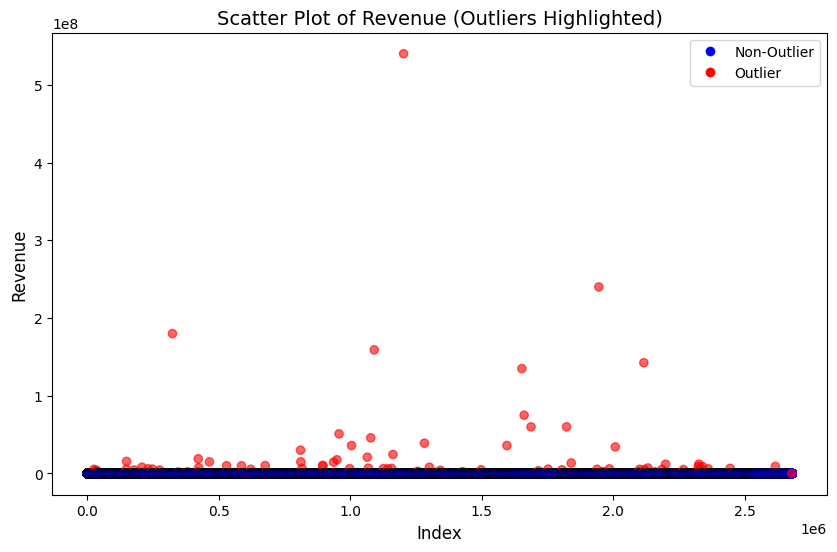

In [73]:
# --- Calculate IQR based outlier boundaries for Revenue ---
Q1 = transactions['Revenue'].quantile(0.25)
Q3 = transactions['Revenue'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# --- Filter out rows with extreme Revenue values ---
outliers_iqr = transactions[(transactions['Revenue'] < lower_bound) | (transactions['Revenue'] > upper_bound)]

# --- Add a column to mark outliers in transactions ---
transactions['Is_Outlier'] = (transactions['Revenue'] < lower_bound) | (transactions['Revenue'] > upper_bound)

# --- Calculate additional statistics for outliers ---
if not outliers_iqr.empty:
    outliers_min = outliers_iqr['Revenue'].min()
    outliers_median = outliers_iqr['Revenue'].median()
    outliers_max = outliers_iqr['Revenue'].max()
    outliers_mean = outliers_iqr['Revenue'].mean()
    outliers_std = outliers_iqr['Revenue'].std()
    outliers_interval = (outliers_min, outliers_max)
    pct_outliers = (len(outliers_iqr) / len(transactions)) * 100

    print("\nOutlier Statistics:")
    print(f"Minimum outlier value: {outliers_min}")
    print(f"Median outlier value: {outliers_median}")
    print(f"Maximum outlier value: {outliers_max}")
    print(f"Mean outlier value: {outliers_mean}")
    print(f"Standard deviation of outliers: {outliers_std}")
    print(f"Outlier interval: {outliers_interval}")
    print(f"Percentage of outliers: {pct_outliers:.2f}%")
else:
    print("No outlier statistics to display.")

# --- Calculate number of negative Revenue values (if applicable) ---
negative_revenue = transactions[transactions['Revenue'] < 0]
num_negative = len(negative_revenue)
if num_negative > 0:
    print(f"\nFound {num_negative} transaction(s) with negative Revenue.")
else:
    print("\nNo negative Revenue values found.")

# --- Create a scatter plot to visualize Revenue and mark outliers ---
plt.figure(figsize=(10, 6))
# Color code: red for outliers, blue for non-outliers
plt.scatter(transactions.index, transactions['Revenue'], 
            c=transactions['Is_Outlier'].map({True: 'red', False: 'blue'}), 
            alpha=0.6)

plt.title('Scatter Plot of Revenue (Outliers Highlighted)', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Revenue', fontsize=12)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Non-Outlier', markerfacecolor='blue', markersize=8),
                   Line2D([0], [0], marker='o', color='w', label='Outlier', markerfacecolor='red', markersize=8)]
plt.legend(handles=legend_elements, loc='upper right')

plt.show()

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_98547/902860573.py:3: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



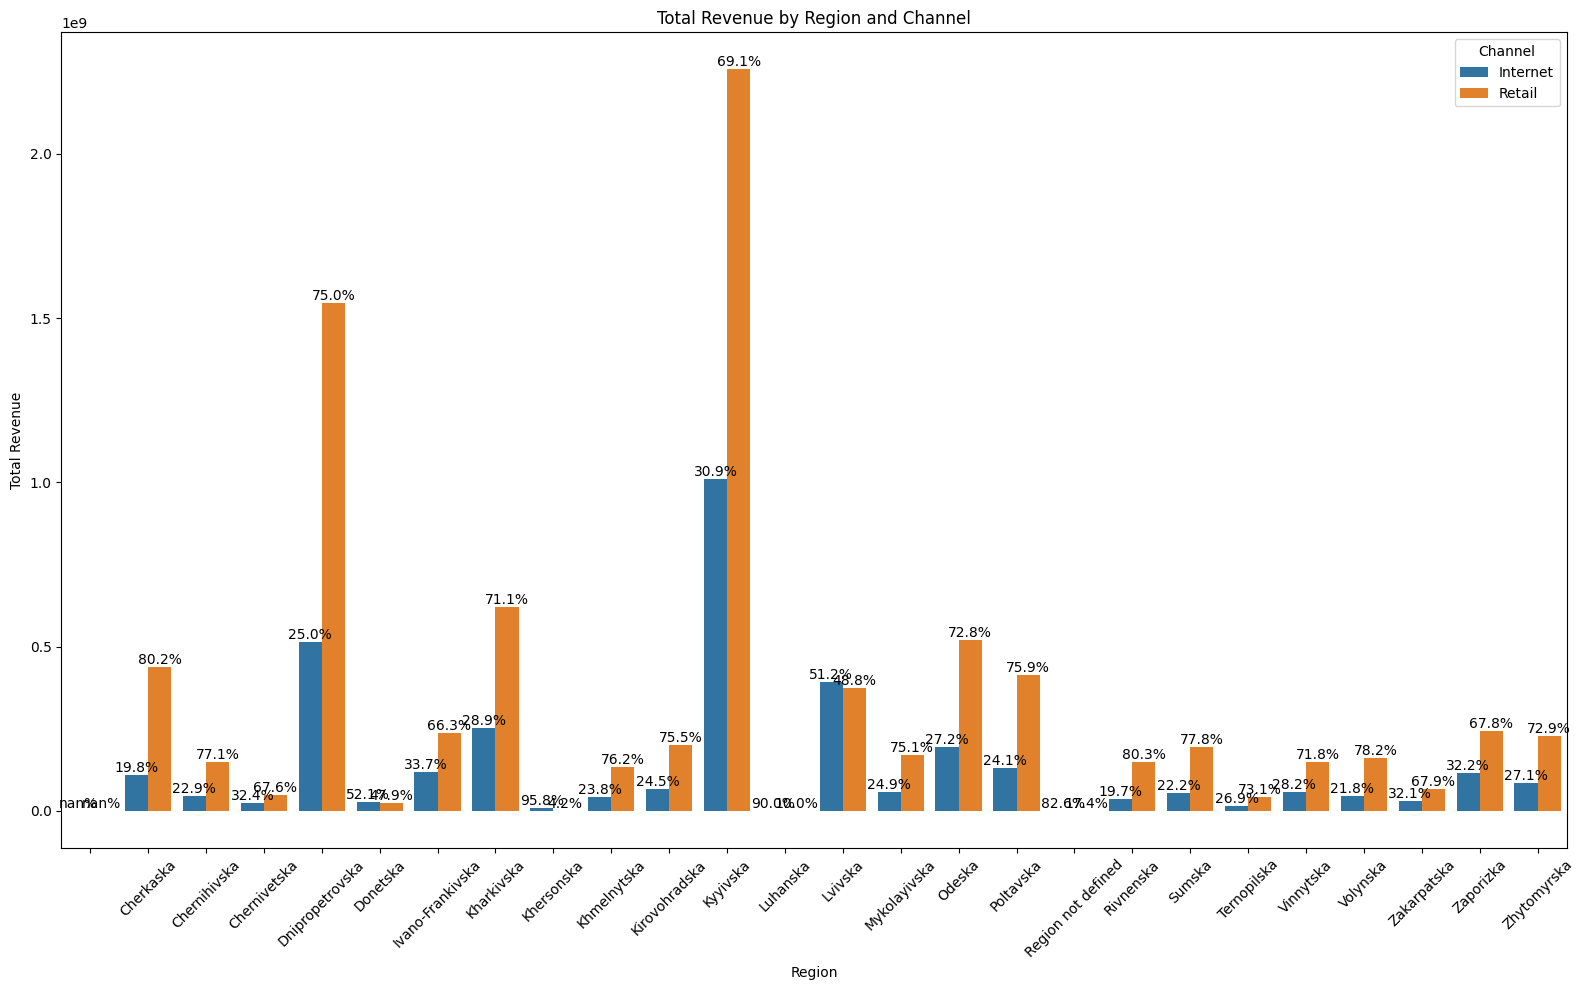

In [74]:
agg_revenue = transactions.groupby(['Channel', 'Region'])['Revenue'].sum().reset_index()
# Calculate total revenue per region
agg_revenue['Percentage'] = agg_revenue.groupby('Region')['Revenue'].apply(lambda x: (x / x.sum()) * 100)

# --- Visualization 1: Grouped Bar Chart with Percentages ---
plt.figure(figsize=(16, 10))
barplot = sns.barplot(data=agg_revenue, x='Region', y='Revenue', hue='Channel')

# Annotate each bar with the percentage
for bar, percentage in zip(barplot.patches, agg_revenue['Percentage']):
    bar_height = bar.get_height()
    barplot.annotate(f'{percentage:.1f}%', 
                     (bar.get_x() + bar.get_width() / 2, bar_height), 
                     ha='center', va='bottom', fontsize=10, color='black')

plt.title("Total Revenue by Region and Channel")
plt.xlabel("Region")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.legend(title="Channel")
plt.tight_layout()
plt.show()

Merge Transactions and client dataset 

In [167]:
# Merge transactions and clients on 'Client_id'
loyalty_data = transactions.merge(clients, on='Client_id', how='inner')

In [168]:
#print first 5 rows of the merged DataFrame
print(loyalty_data.columns)


Index(['City', 'Date', 'Receipt_id', 'Sale_Return', 'Client_id', 'Channel',
       'Platform', 'Credit', 'SKU_id', 'Business', 'Brand', 'Category',
       'Region', 'Revenue', 'Quantity', 'City_On_Off', 'Category_Ukr',
       'Registration_date', 'Gender', 'Age', 'Number_of_receipts',
       'Total_revenue'],
      dtype='object')


In [169]:
# Calculate average order value per client
loyalty_data['AOV'] = loyalty_data['Revenue'] / loyalty_data['Number_of_receipts']

In [170]:
# Convert 'Registration_date' to datetime
loyalty_data['Registration_date'] = pd.to_datetime(loyalty_data['Registration_date'], errors='coerce')

In [171]:
print(loyalty_data['Registration_date'].dtype)

datetime64[ns]


   Client_id  Total_revenue  Number_of_receipts  Customer_Lifetime_Years  \
0  674537053          42764                  17                 7.416838   
1  674537053          42764                  17                 7.416838   
2  674537053          42764                  17                 7.416838   
3  674537053          42764                  17                 7.416838   
4  674537053          42764                  17                 7.416838   

         AOV  Annual_Revenue  Estimated_CLV  
0  64.588235     5765.799557   28828.997785  
1   0.058824     5765.799557   28828.997785  
2 -41.058824     5765.799557   28828.997785  
3  -0.058824     5765.799557   28828.997785  
4  10.823529     5765.799557   28828.997785  


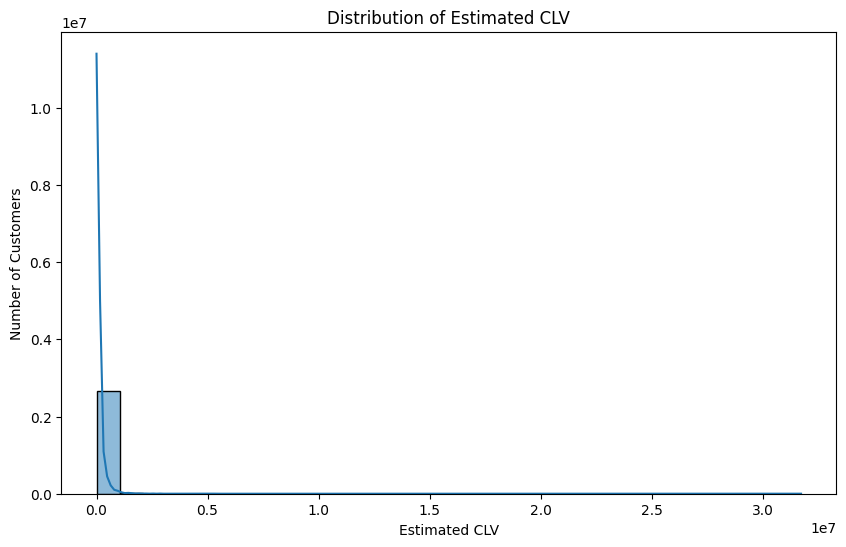

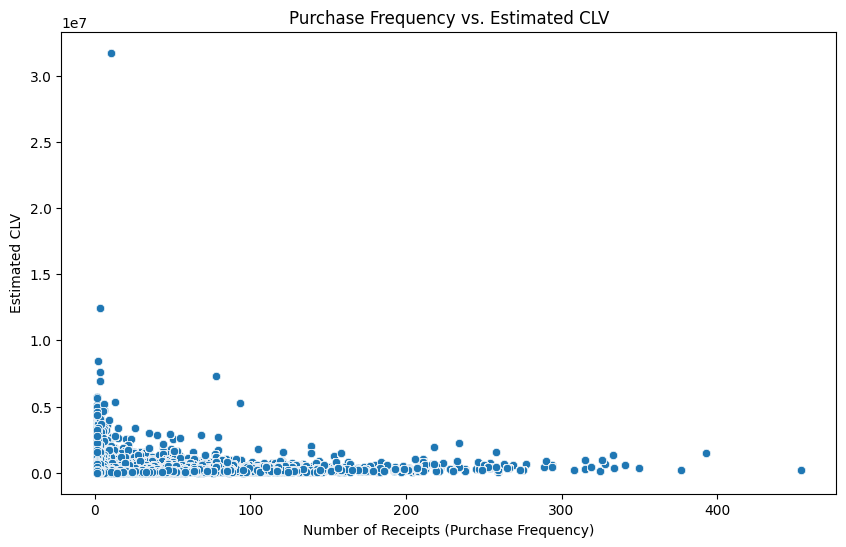

In [179]:
current_date = pd.to_datetime('today')
loyalty_data['Customer_Lifetime_Years'] = (current_date - loyalty_data['Registration_date']).dt.days / 365.25

loyalty_data['Annual_Revenue'] = loyalty_data['Total_revenue'] / loyalty_data['Customer_Lifetime_Years']

# Assume an average future customer lifespan (in years), e.g., 5 years
assumed_future_lifetime = 5

# Estimate CLV: projected future revenue over the assumed future lifetime
loyalty_data['Estimated_CLV'] = loyalty_data['Annual_Revenue'] * assumed_future_lifetime

print(loyalty_data[['Client_id', 'Total_revenue', 'Number_of_receipts', 
                    'Customer_Lifetime_Years', 'AOV', 'Annual_Revenue', 'Estimated_CLV']].head())


# 1. Histogram of Estimated CLV distribution
plt.figure(figsize=(10,6))
sns.histplot(loyalty_data['Estimated_CLV'], bins=30, kde=True)
plt.title('Distribution of Estimated CLV')
plt.xlabel('Estimated CLV')
plt.ylabel('Number of Customers')
plt.show()

# 2. Scatter plot: Purchase Frequency (Number_of_receipts) vs. Estimated CLV
plt.figure(figsize=(10,6))
sns.scatterplot(x='Number_of_receipts', y='Estimated_CLV', data=loyalty_data)
plt.title('Purchase Frequency vs. Estimated CLV')
plt.xlabel('Number of Receipts (Purchase Frequency)')
plt.ylabel('Estimated CLV')
plt.show()


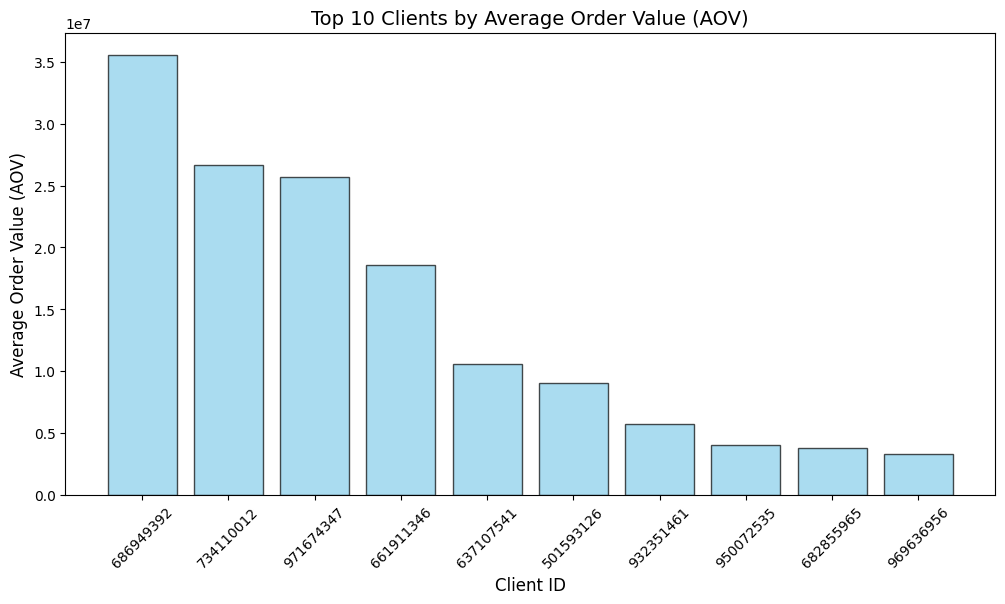

In [117]:
# Sort by AOV and select top 10 clients for visualization
top_clients = loyalty_data.nlargest(10, 'AOV')

# Plot a vertical bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_clients['Client_id'].astype(str), top_clients['AOV'], color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.title('Top 10 Clients by Average Order Value (AOV)', fontsize=14)
plt.xlabel('Client ID', fontsize=12)
plt.ylabel('Average Order Value (AOV)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)

# Show the plot
plt.show()

Curate list of top 10,000 clients to give them loyalty points <br>
Curate list with least AOL and then try to retain them <br>

In [139]:
# Select top 10,000 clients by AOV and ensure unique Client_id
top_10000_clients = loyalty_data.nlargest(10000, 'AOV').drop_duplicates(subset='Client_id')
top_10000_clients.to_csv('Comfy_Data/top_10000_clients.csv', index=False)

# Select bottom 10,000 clients by AOV and ensure unique Client_id
bottom_10000_clients = loyalty_data.nsmallest(10000, 'AOV').drop_duplicates(subset='Client_id')
bottom_10000_clients.to_csv('Comfy_Data/bottom_10000_clients.csv', index=False)

**RFM Analysis**

Segment customers based on Recency, Frequency, and Monetary values.
Identify segments such as “Best Customers,” “Loyal Customers,” “At-Risk Customers,” etc.

In [172]:
# Set the reference date for recency calculations (day after the most recent transaction)
analysis_date = transactions['Date'].max() + pd.Timedelta(days=1)

# Group by Client_id and compute RFM metrics
rfm = transactions.groupby('Client_id').agg({
    'Date': lambda x: (analysis_date - x.max()).days,  # Recency
    'Receipt_id': 'count',                              # Frequency
    'Revenue': 'sum'                                    # Monetary
})

# Rename columns for clarity
rfm.rename(columns={'Date': 'Recency', 'Receipt_id': 'Frequency', 'Revenue': 'Monetary'}, inplace=True)

# For Recency: lower recency (more recent) should have a higher score.
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# For Frequency: higher frequency is better.
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# For Monetary: higher spending is better.
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)


# Create a combined RFM score string
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [173]:
def segment_customer(row):
    if row['R_Score'] >= 4 and row['F_Score'] >= 4 and row['M_Score'] >= 4:
        return 'Best Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    else:
        return 'At Risk'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

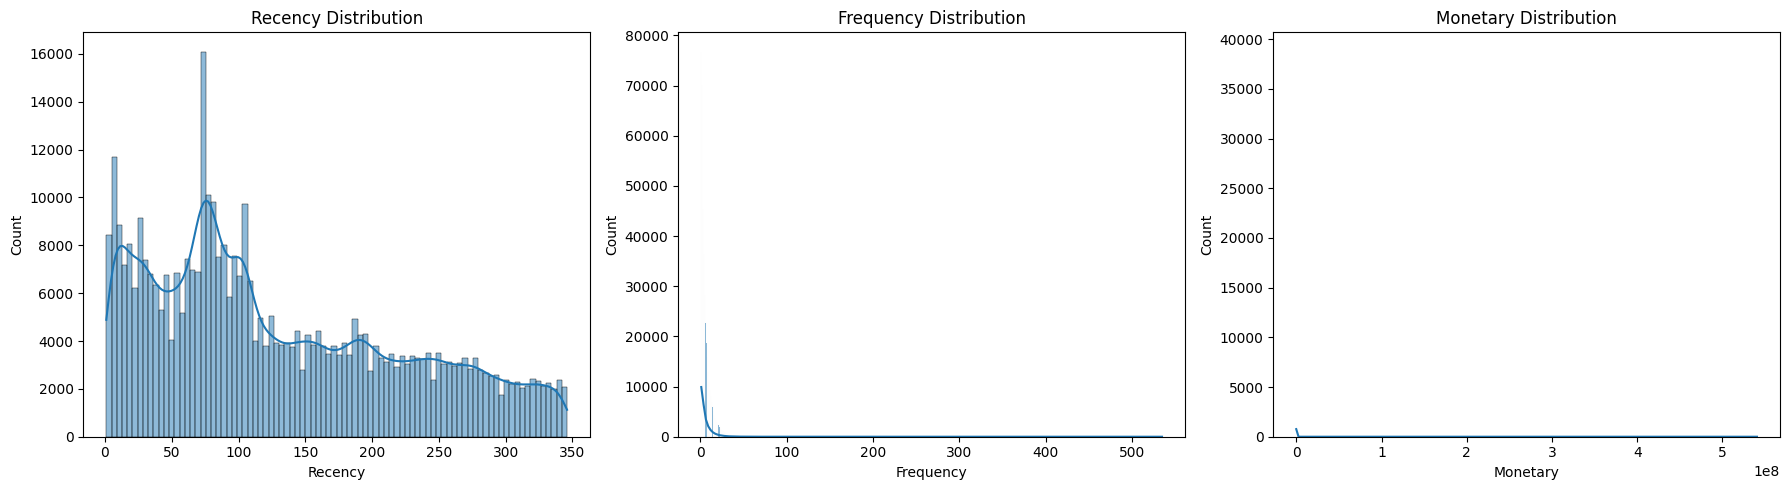

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], ax=axes[0], kde=True)
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], ax=axes[1], kde=True)
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], ax=axes[2], kde=True)
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

Assignment 1.3 3D Scatter Plot

In [186]:
# Reset the index so Client_id becomes a column
rfm_reset = rfm.reset_index()

# Filter out rows with negative Monetary values
rfm_reset = rfm_reset[rfm_reset['Monetary'] >= 0]


# Now, use the filtered DataFrame for the 3D scatter plot
fig = px.scatter_3d(
    rfm_reset, 
    x='Frequency', 
    y='Recency', 
    z='Monetary', 
    color='Segment',
    size='Monetary',   # Using Monetary as a proxy for customer value
    hover_data=['Client_id'],
    title="3D Scatter Plot: Customer Behavior by Segment"
)
fig.write_html('3D_Scatter_Plot.html')

Customers who are either flagged as “At Risk” by your RFM segmentation or who have low purchase frequency (defined here as being in the bottom 25% of frequency)

-> Consider retention campaigns like personalized discount offers or incentives to increase purchase frequency.

In [120]:
# Filter customers that are classified as "At Risk" based on your RFM segmentation
at_risk_customers = rfm[rfm['Segment'] == 'At Risk']

# Identify customers with low frequency (e.g., those in the bottom 25% of Frequency)
low_freq_threshold = rfm['Frequency'].quantile(0.25)
low_frequency_customers = rfm[rfm['Frequency'] <= low_freq_threshold]

# Combine both groups and drop any duplicates
at_risk_or_low_frequency = pd.concat([at_risk_customers, low_frequency_customers]).drop_duplicates()

# Display the resulting DataFrame
print("At Risk or Low Frequency Customers:")
print(at_risk_or_low_frequency)

At Risk or Low Frequency Customers:
           Recency  Frequency  Monetary  R_Score  F_Score  M_Score RFM_Score  \
Client_id                                                                      
335026407      164          1    1276.0        2        1        1       211   
372456105      305          1    7999.0        1        1        3       113   
381523648      226          1    1429.0        1        1        1       111   
442348055      204          2    6653.0        2        1        3       213   
443000507      253          1    2999.0        1        1        2       112   
...            ...        ...       ...      ...      ...      ...       ...   
999873457      226          4    4298.0        1        3        2       132   
999875186       54          3    3889.0        4        2        2       422   
999877795      227          6    9785.0        1        4        3       143   
999879296       12          4    3149.0        5        3        2       532   
9998

Merg of loyalty data and rfm 

In [174]:
loyalty_data = loyalty_data.merge(rfm[['Segment']], left_on='Client_id', right_index=True, how='left')


In [175]:
# Print unique values and their counts for Segment
print("Unique values in 'Segment' and their counts:")
print(loyalty_data['Segment'].value_counts())
print("\n")

# Print unique values and their counts for Channel
print("Unique values in 'Channel' and their counts:")
print(loyalty_data['Channel'].value_counts())
print("\n")

# Check if there are any missing values in Segment or Channel
print("Missing values in 'Segment':", loyalty_data['Segment'].isna().sum())
print("Missing values in 'Channel':", loyalty_data['Channel'].isna().sum())

Unique values in 'Segment' and their counts:
Best Customers     1071499
At Risk            1023922
Loyal Customers     584495
Name: Segment, dtype: int64


Unique values in 'Channel' and their counts:
Retail      1808405
Internet     871511
Name: Channel, dtype: int64


Missing values in 'Segment': 0
Missing values in 'Channel': 0


           Segment   Channel  Total_revenue  Number_of_receipts
0          At Risk  Internet    11877175564             2692742
1          At Risk    Retail    34455432433             6113513
2   Best Customers  Internet    48140710670             9664025
3   Best Customers    Retail   116319015506            19204084
4  Loyal Customers  Internet    12252152831             2718955
5  Loyal Customers    Retail    32315666363             5395935


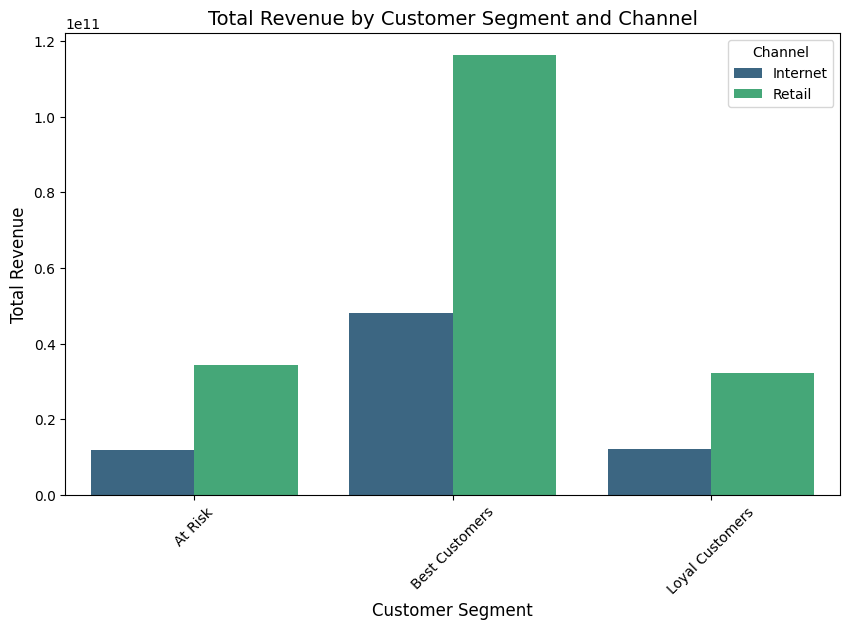

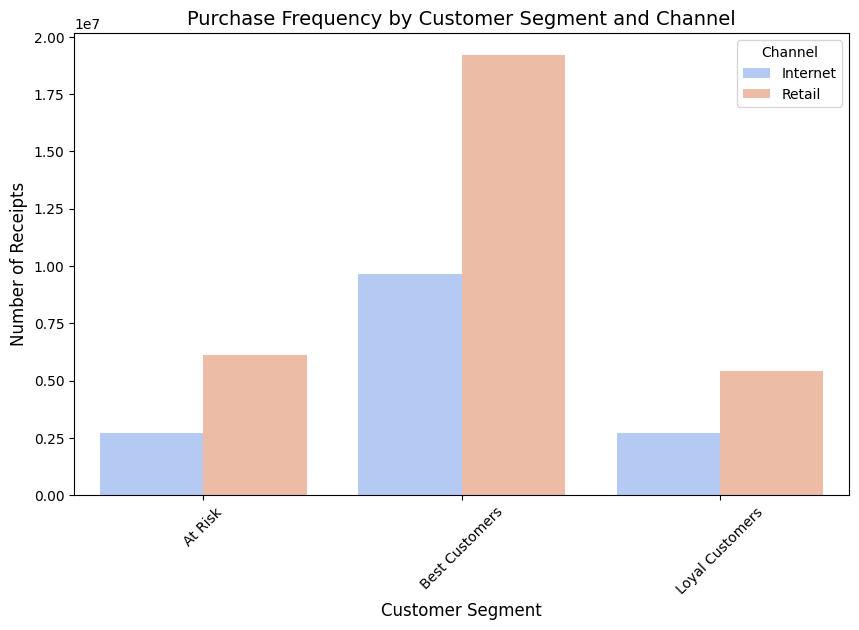

In [123]:
seg_channel = loyalty_data.groupby(['Segment', 'Channel']).agg({
    'Total_revenue': 'sum',
    'Number_of_receipts': 'sum'
}).reset_index()

# Check the grouped data
print(seg_channel)

# Visualization: Total Revenue by Customer Segment and Channel
plt.figure(figsize=(10, 6))
sns.barplot(data=seg_channel, x='Segment', y='Total_revenue', hue='Channel', palette='viridis')
plt.title('Total Revenue by Customer Segment and Channel', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.legend(title='Channel')
plt.xticks(rotation=45)
plt.show()

# Visualization: Number of Receipts by Customer Segment and Channel
plt.figure(figsize=(10, 6))
sns.barplot(data=seg_channel, x='Segment', y='Number_of_receipts', hue='Channel', palette='coolwarm')
plt.title('Purchase Frequency by Customer Segment and Channel', fontsize=14)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Receipts', fontsize=12)
plt.legend(title='Channel')
plt.xticks(rotation=45)
plt.show()

In [161]:
# Merge segmentation from rfm into clients DataFrame
clients_seg = clients.merge(rfm[['Segment']], left_on='Client_id', right_index=True, how='left')

In [125]:
segment_revenue = clients_seg.groupby('Segment')['Total_revenue'].sum().reset_index()

# Calculate percentage contribution for each segment
total_revenue = segment_revenue['Total_revenue'].sum()
segment_revenue['Pct_Contribution'] = (segment_revenue['Total_revenue'] / total_revenue) * 100

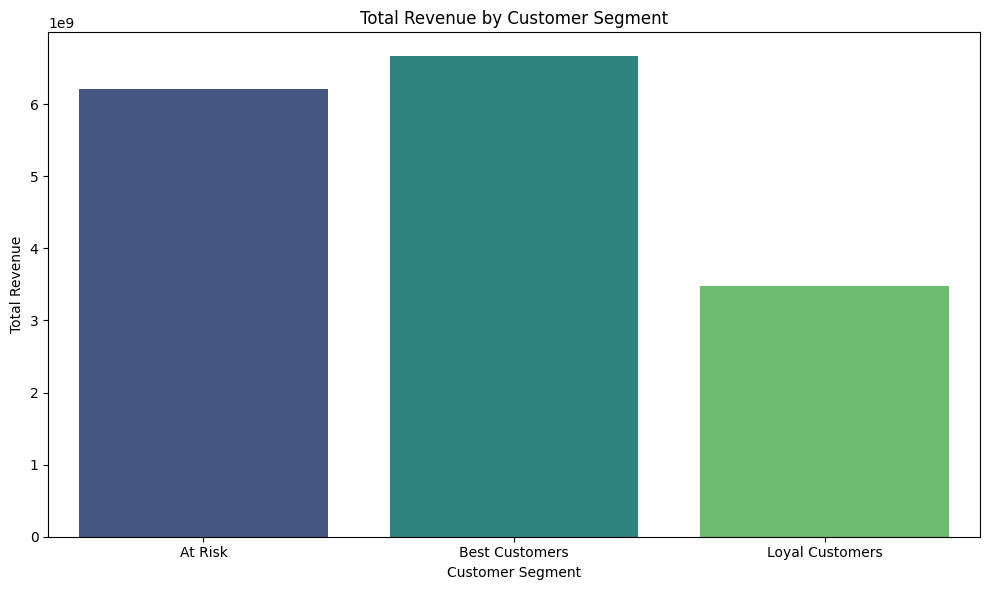

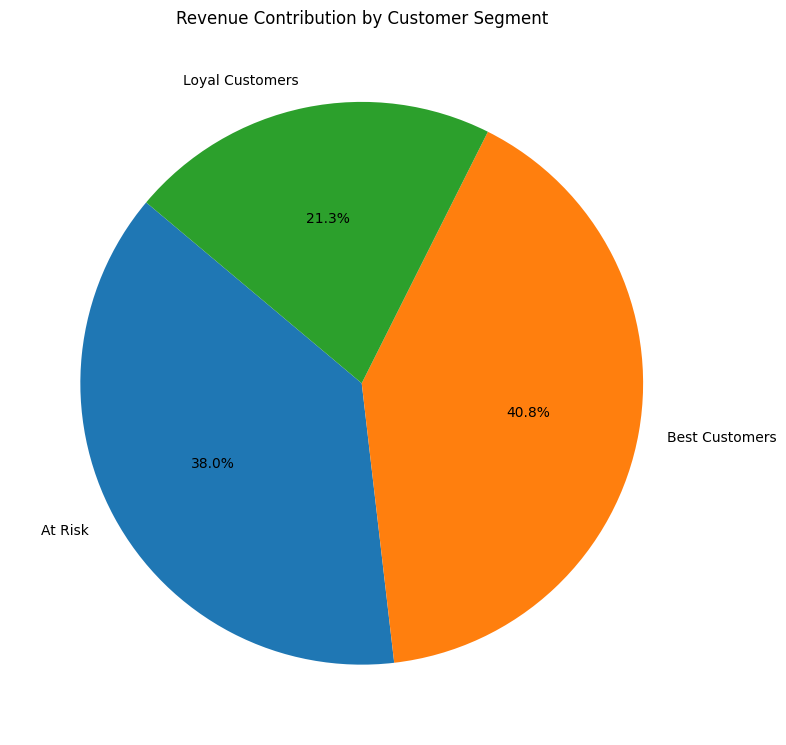

In [126]:
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_revenue, x='Segment', y='Total_revenue', palette='viridis')
plt.title("Total Revenue by Customer Segment")
plt.xlabel("Customer Segment")
plt.ylabel("Total Revenue")
plt.tight_layout()
plt.show()


plt.figure(figsize=(8,8))
plt.pie(segment_revenue['Total_revenue'], labels=segment_revenue['Segment'], autopct='%1.1f%%', startangle=140)
plt.title("Revenue Contribution by Customer Segment")
plt.tight_layout()
plt.show()

<h1>Assignment 1.3</h1>

In [181]:
# Merge loyalty_data with rfm to include Frequency, Recency, and Monetary columns
loyalty_data_merged = loyalty_data.merge(rfm[['Frequency', 'Recency', 'Monetary']], 
                                         left_on='Client_id', 
                                         right_index=True, 
                                         how='inner')

In [182]:
print("Columns in merged DataFrame:", loyalty_data_merged.columns.tolist())

Columns in merged DataFrame: ['City', 'Date', 'Receipt_id', 'Sale_Return', 'Client_id', 'Channel', 'Platform', 'Credit', 'SKU_id', 'Business', 'Brand', 'Category', 'Region', 'Revenue', 'Quantity', 'City_On_Off', 'Category_Ukr', 'Registration_date', 'Gender', 'Age', 'Number_of_receipts', 'Total_revenue', 'AOV', 'Segment', 'Customer_Lifetime_Years', 'Annual_Revenue', 'Estimated_CLV', 'Frequency', 'Recency', 'Monetary']


In [ ]:
rfm_bubble = loyalty_data_merged.dropna(subset=['Frequency', 'Recency', 'Estimated_CLV', 'Segment'])

# Reducing outliers for better scaling
rfm_bubble = rfm_bubble[rfm_bubble['Estimated_CLV'] < rfm_bubble['Estimated_CLV'].quantile(0.99)]


fig = px.scatter(
    rfm_bubble,
    x='Frequency',
    y='Recency',
    size='Estimated_CLV',
    color='Segment',  
    hover_data=['Client_id'],
    size_max=60,
    title='Customer Segments: Frequency vs Recency (Bubble = CLV)'
)

fig.update_layout(xaxis_title='Frequency', yaxis_title='Recency (days)')
fig.write_html('Customer_Segments_Frequency_vs_Recency.html')

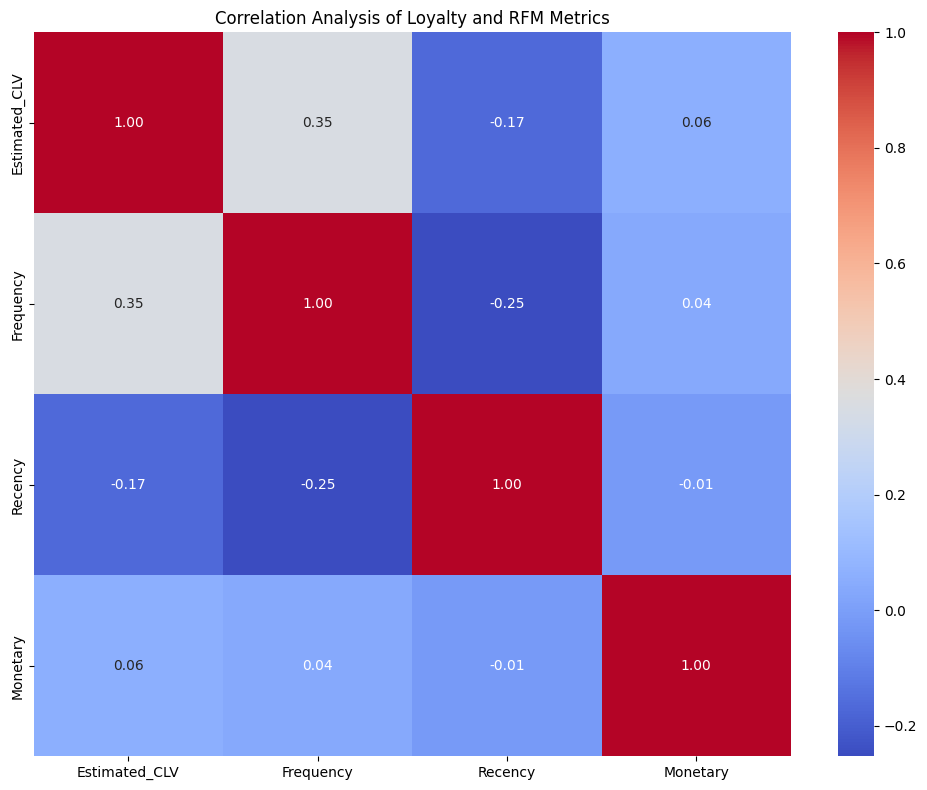

In [95]:
numeric_cols = ['Estimated_CLV', 'Frequency', 'Recency', 'Monetary']

# Filter the list to those that actually exist in the merged DataFrame.
numeric_cols = [col for col in numeric_cols if col in loyalty_data_merged.columns]

# Compute the correlation matrix using Pearson’s method.
corr_matrix = loyalty_data_merged[numeric_cols].corr()

# Plot the correlation heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis of Loyalty and RFM Metrics")
plt.tight_layout()
plt.show()

In [96]:
# Merge the segmentation from rfm into the clients dataset using Client_Id as key.
clients_seg = clients.merge(rfm[['Segment']], left_on='Client_id', right_index=True, how='left')
print(clients_seg.head())

   Client_id Registration_date Gender Age  Number_of_receipts  Total_revenue  \
0  509785107        11/30/2019      -  41                  68        3067388   
1  967337576         7/19/2018      -  36                 234        3002606   
2  675309125         1/25/2014      -  63                 154        2822662   
3  663403250         7/13/2023      -  22                  78        2556307   
4  675931029         5/31/2016   male  40                 333        2407277   

           Segment  
0   Best Customers  
1  Loyal Customers  
2   Best Customers  
3   Best Customers  
4   Best Customers  


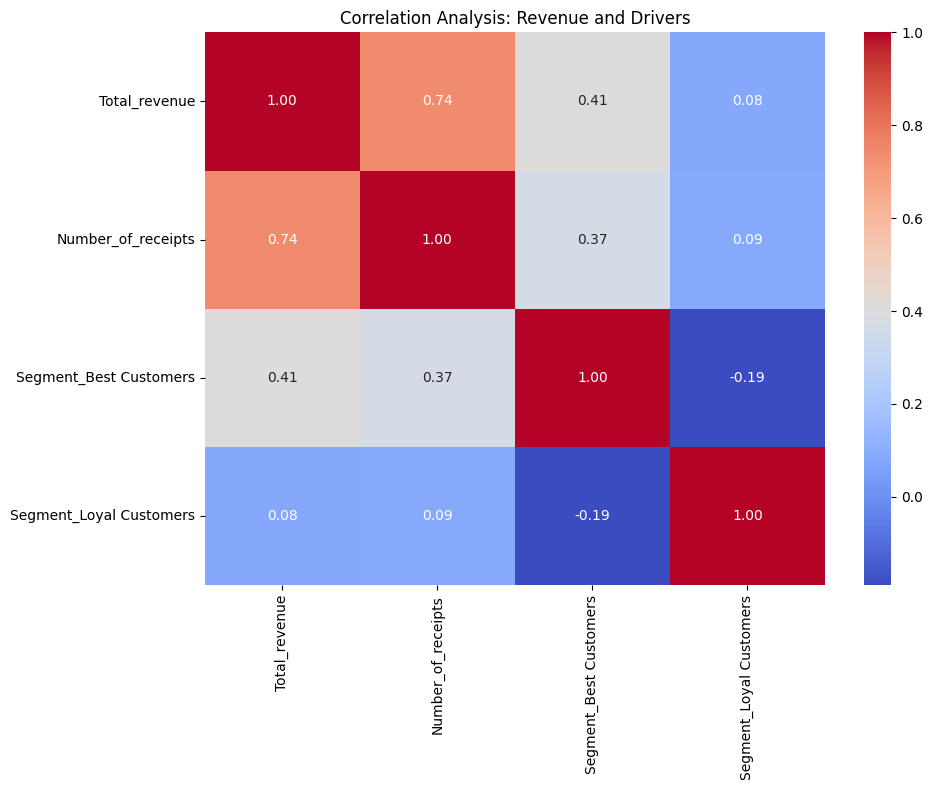

In [97]:
# One-hot encode the 'Segment' column.
clients_encoded = pd.get_dummies(clients_seg, columns=['Segment'], drop_first=True)

# Define numeric columns for correlation analysis.
# Adjust column names as per your dataset; here, we use 'Total_revenue' and 'Number_of_receipts'.
segment_cols = [col for col in clients_encoded.columns if col.startswith('Segment_')]
numeric_cols = ['Total_revenue', 'Number_of_receipts'] + segment_cols

# Compute the correlation matrix.
corr_matrix = clients_encoded[numeric_cols].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Analysis: Revenue and Drivers")
plt.tight_layout()
plt.show()

The Random Forest model’s importance scores indicate which variables have the greatest impact on predicting Total_revenue. This helps identify the key revenue drivers <br>
-Number_of_receipts shows a high importance score, then increasing purchase frequency should be a strategic focus.

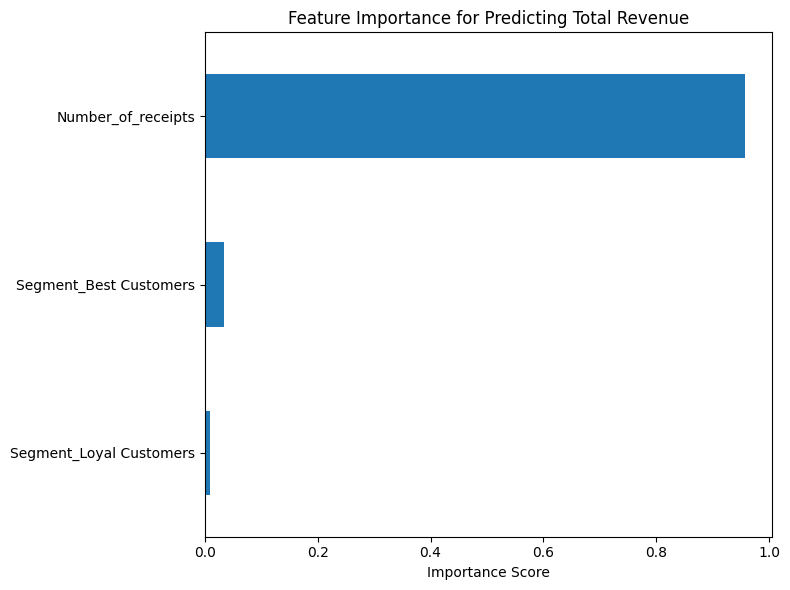

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare feature matrix (X) and target variable (y).
X = clients_encoded[['Number_of_receipts'] + segment_cols]
y = clients_encoded['Total_revenue']

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Regressor.
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores.
importances = rf_model.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values()

# Plot the feature importance.
plt.figure(figsize=(8, 6))
feat_importances.plot(kind='barh')
plt.title("Feature Importance for Predicting Total Revenue")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [129]:

# Reset index so that Client_id becomes a column if it is not already
loyalty_data_reset = loyalty_data_merged.reset_index(drop=True)
print(loyalty_data_reset.head())
print(loyalty_data_reset.info())

         City       Date                  Receipt_id  Sale_Return  Client_id  \
0  Kam'yanske 2023-05-22       22.05.2023-ЧDNZ7-0001            1  674537053   
1  Kam'yanske 2023-05-22       22.05.2023-ЧDNZ7-0001            1  674537053   
2  Kam'yanske 2023-05-22  22.05.2023-ВНDNZ-000001040            0  674537053   
3  Kam'yanske 2023-05-22  22.05.2023-ВНDNZ-000001040            0  674537053   
4       Samar 2024-12-23     23.12.2024-Ч003823-0011            1  674537053   

    Channel Platform  Credit   SKU_id     Business  ... Number_of_receipts  \
0    Retail                0  2194716  Accessories  ...                 17   
1    Retail                0  1913004  Accessories  ...                 17   
2    Retail                0  1950622  Accessories  ...                 17   
3    Retail                0  1913004  Accessories  ...                 17   
4  Internet      web       0  1220435   COMFY HOME  ...                 17   

  Total_revenue        AOV  Customer_Lifetime_Year

<h1>Assignment 1.2 Continues</h1> <br>
Age Distribution 

In [130]:
loyalty_data['Age'] = pd.to_numeric(loyalty_data['Age'], errors='coerce')

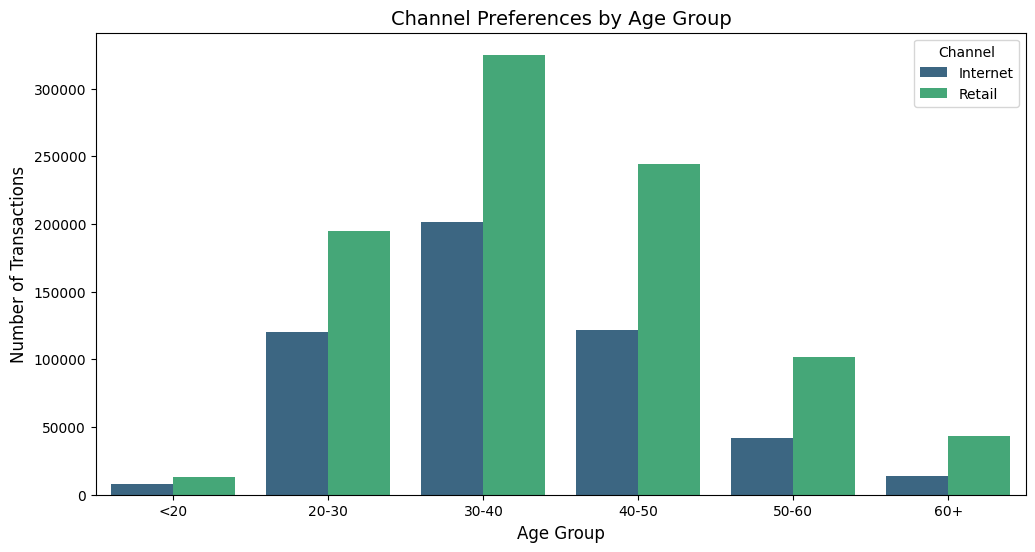

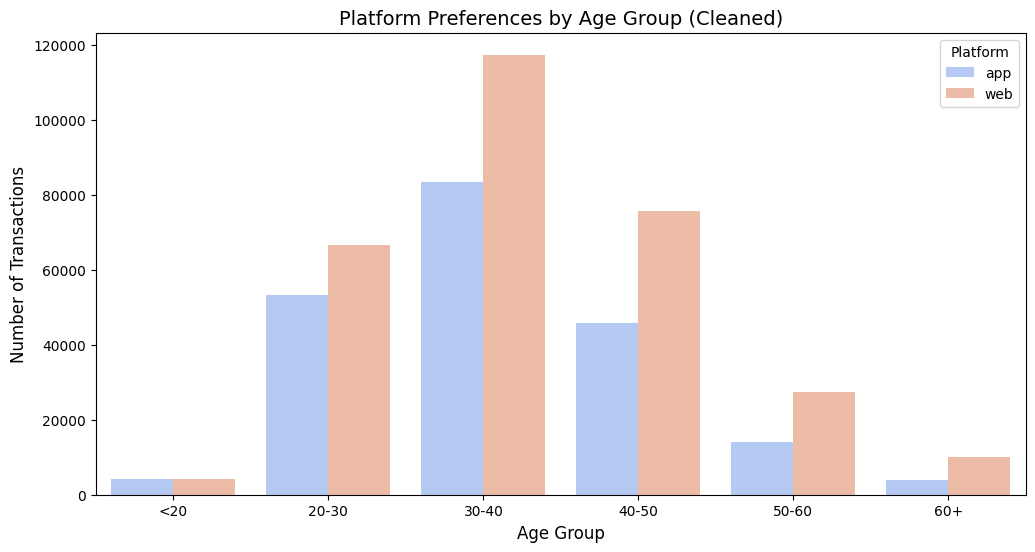

In [131]:
# Create age groups using the Age column in loyalty_data
loyalty_data['Age_Group'] = pd.cut(loyalty_data['Age'], bins=[0, 20, 30, 40, 50, 60, 100], 
                                   labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])

# Group by Age_Group and Channel to count transactions
age_channel_counts = loyalty_data.groupby(['Age_Group', 'Channel']).size().reset_index(name='Count')

# Plot a grouped bar chart to compare channel preferences by age group
plt.figure(figsize=(12, 6))
sns.barplot(x='Age_Group', y='Count', hue='Channel', data=age_channel_counts, palette='viridis')

# Add labels and title
plt.title('Channel Preferences by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.legend(title='Channel')
plt.show()

loyalty_data = loyalty_data[~loyalty_data['Platform'].isin([' ', '-'])]

# Group by Age_Group and Platform to count transactions
age_platform_counts = loyalty_data.groupby(['Age_Group', 'Platform']).size().reset_index(name='Count')

# Plot a grouped bar chart to compare platform preferences by age group
plt.figure(figsize=(12, 6))
sns.barplot(x='Age_Group', y='Count', hue='Platform', data=age_platform_counts, palette='coolwarm')

# Add labels and title
plt.title('Platform Preferences by Age Group (Cleaned)', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.legend(title='Platform')
plt.show()

Region based analysis 

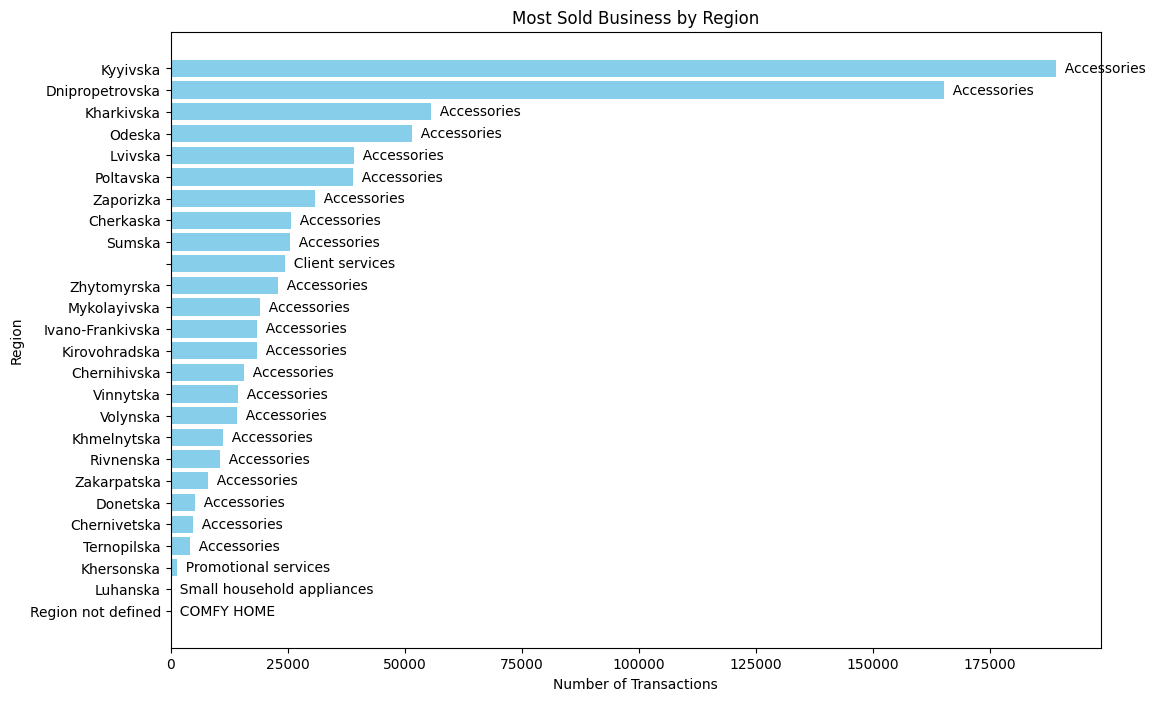

In [132]:
# Compute the business with the highest sales in each region
region_business = transactions.groupby(['Region', 'Business']).size().reset_index(name='Sales')
# For each region, get the business with maximum sales
idx = region_business.groupby('Region')['Sales'].idxmax()
top_business_per_region = region_business.loc[idx].sort_values('Sales', ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(12,8))
plt.barh(top_business_per_region['Region'], top_business_per_region['Sales'], color='skyblue')
for i, v in enumerate(top_business_per_region['Sales']):
    plt.text(v, i, f"  {top_business_per_region['Business'].iloc[i]}", va='center')
plt.title('Most Sold Business by Region')
plt.xlabel('Number of Transactions')
plt.ylabel('Region')
plt.show()

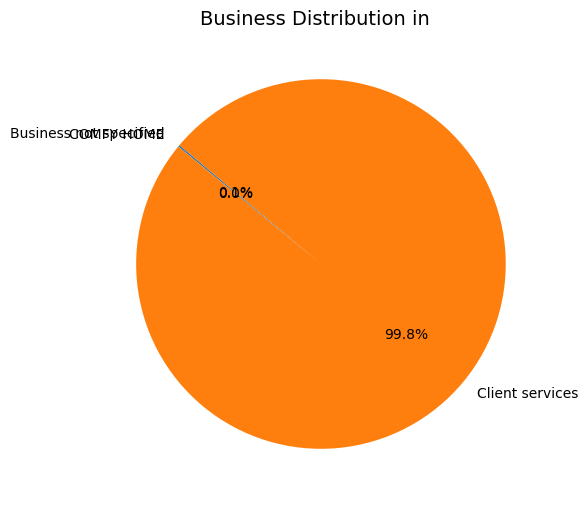

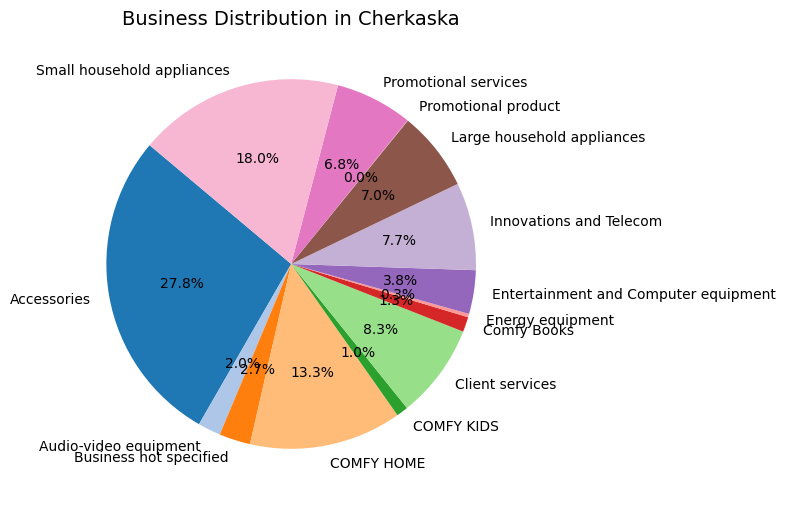

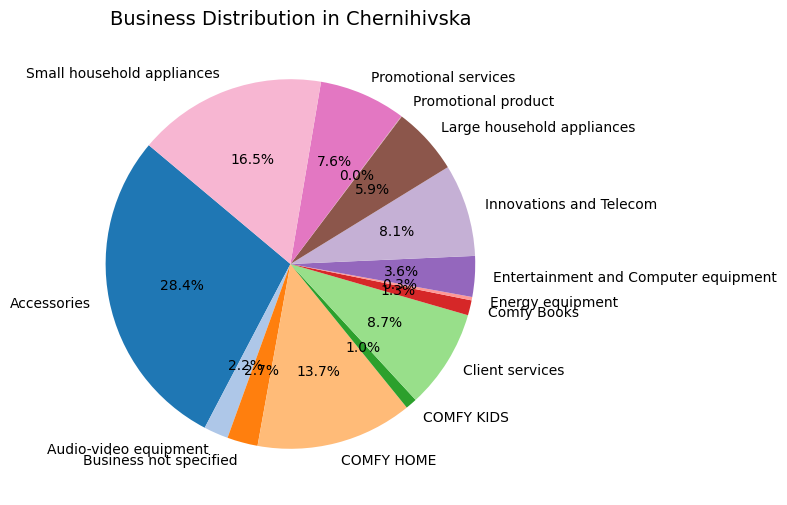

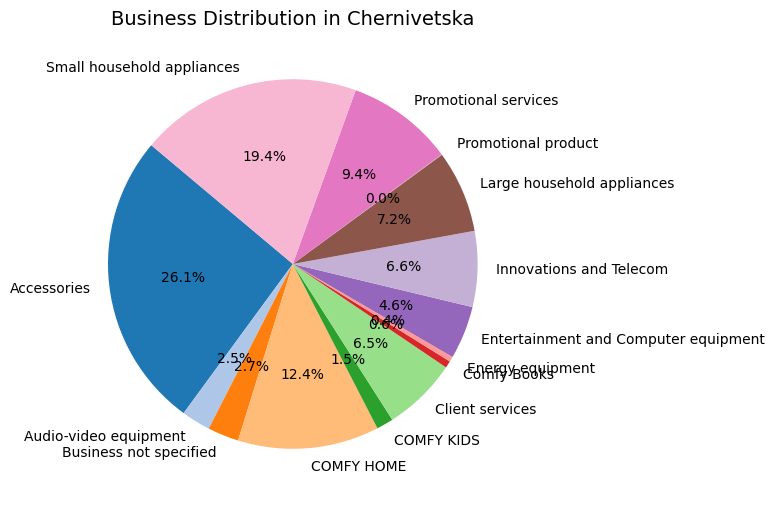

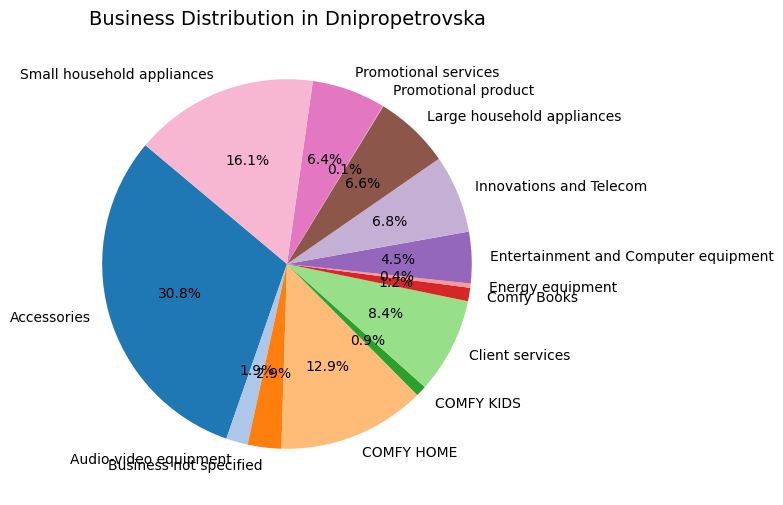

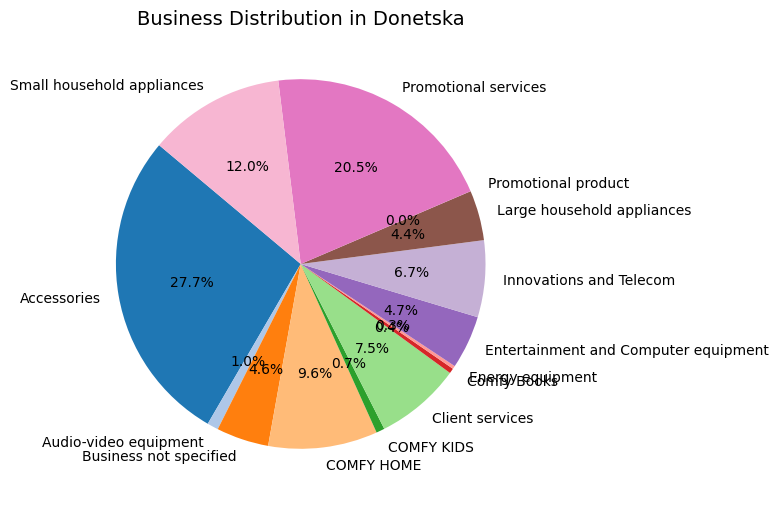

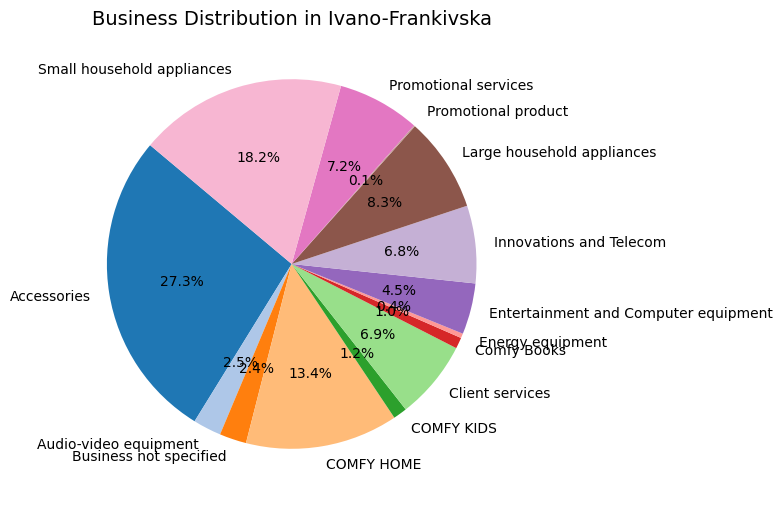

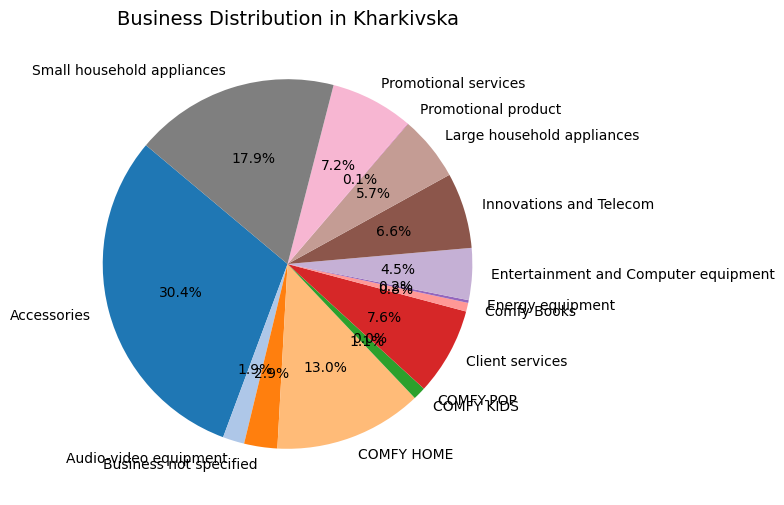

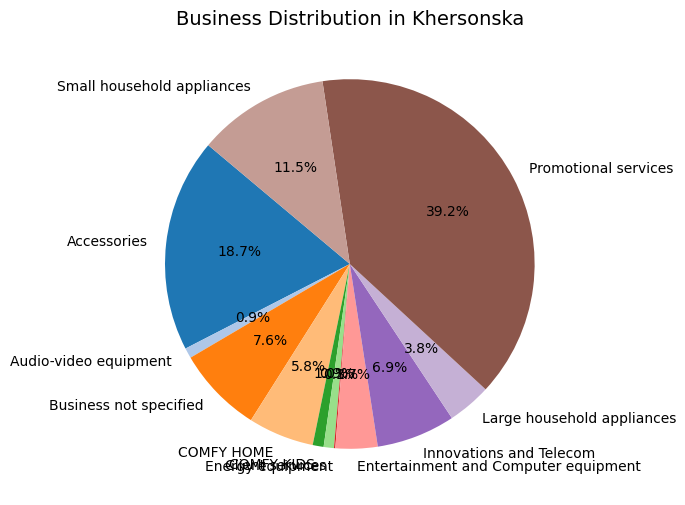

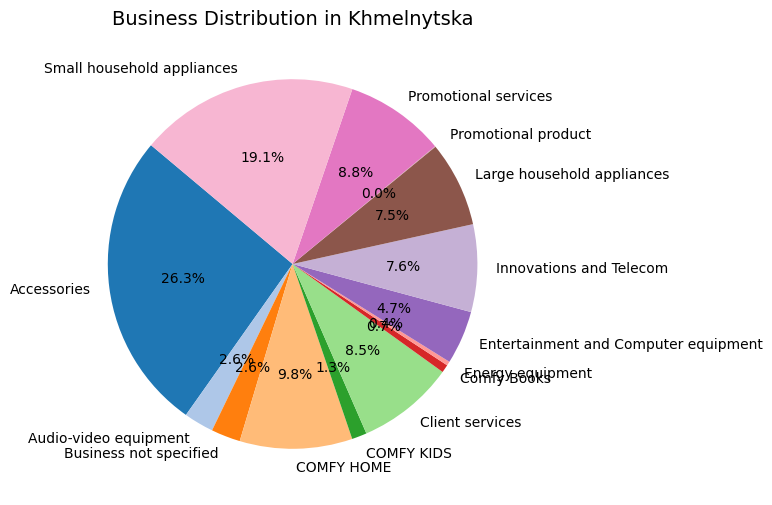

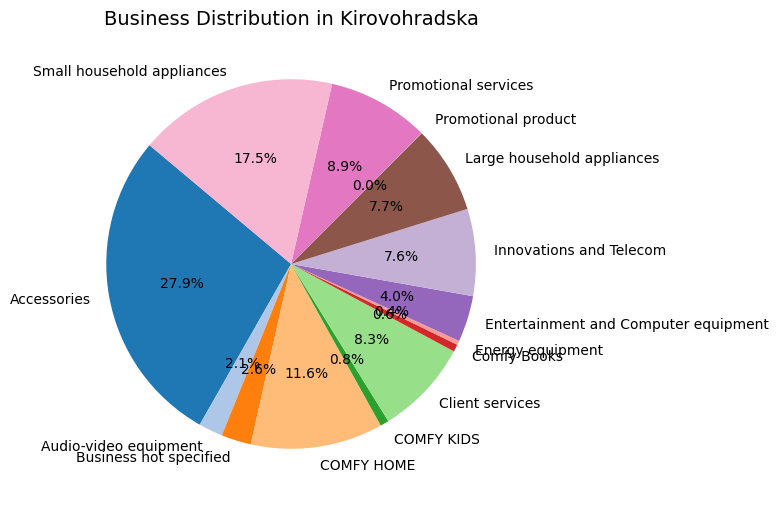

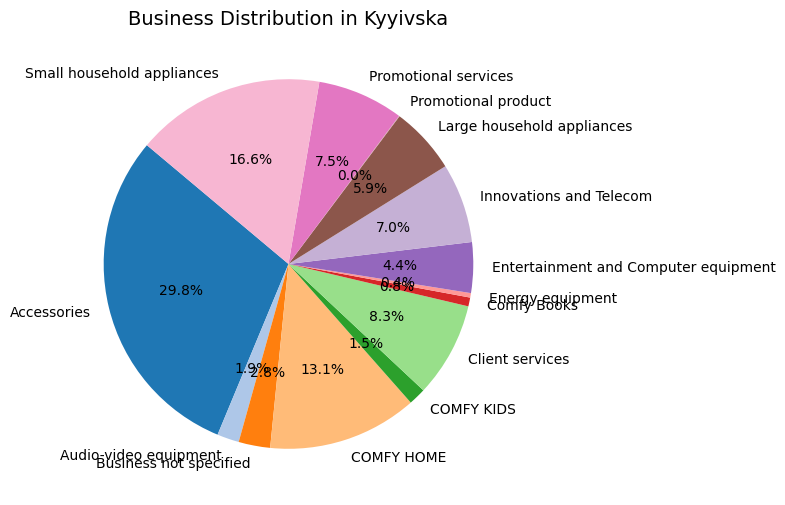

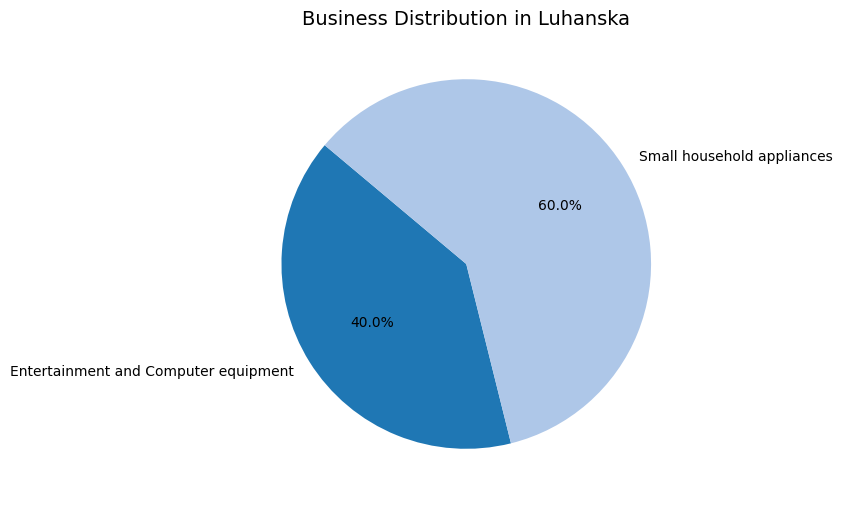

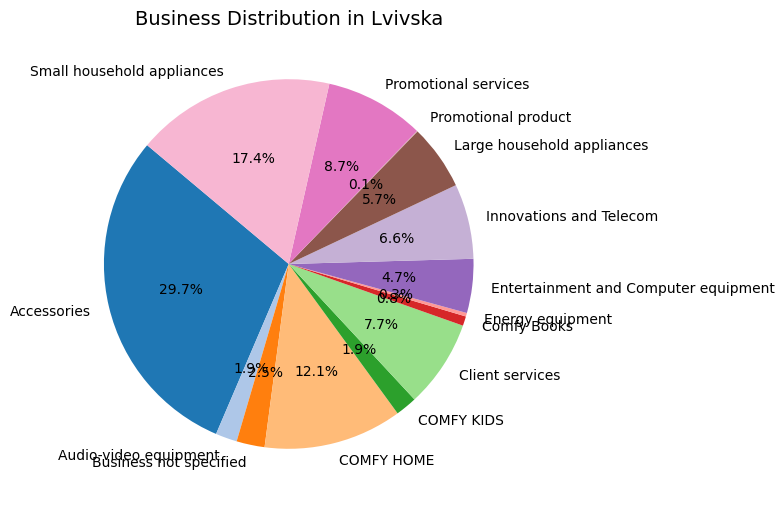

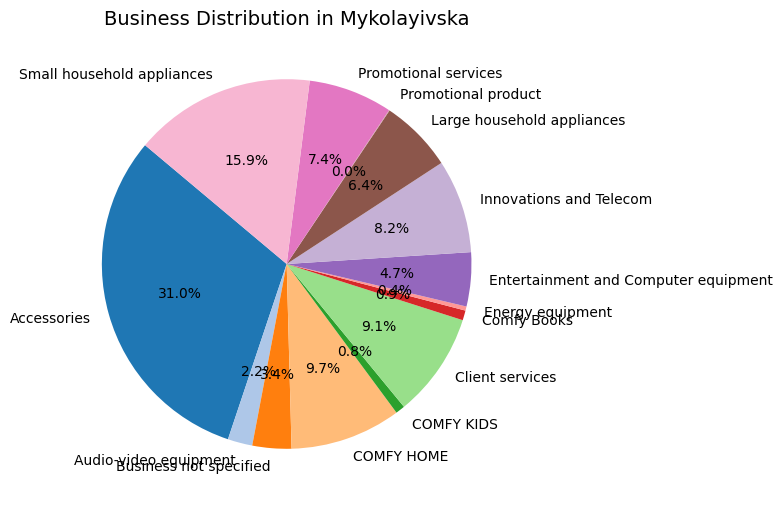

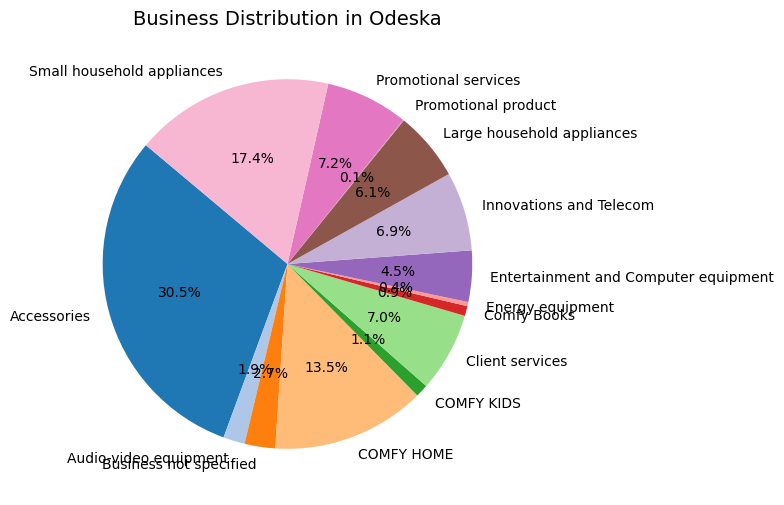

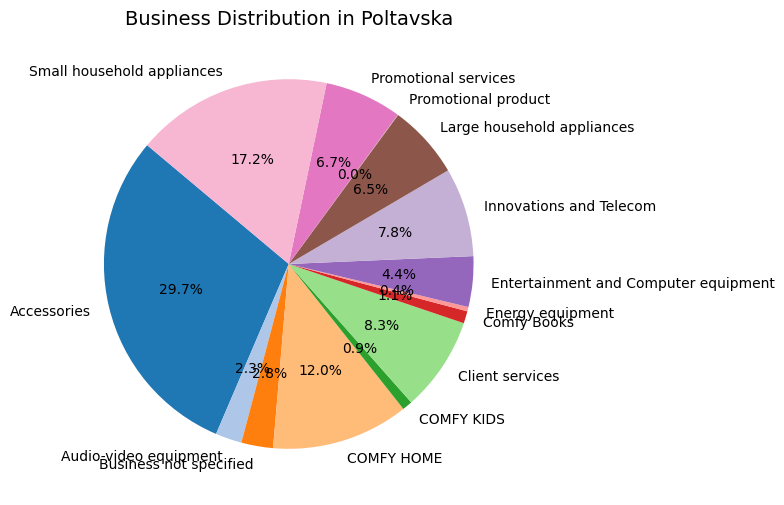

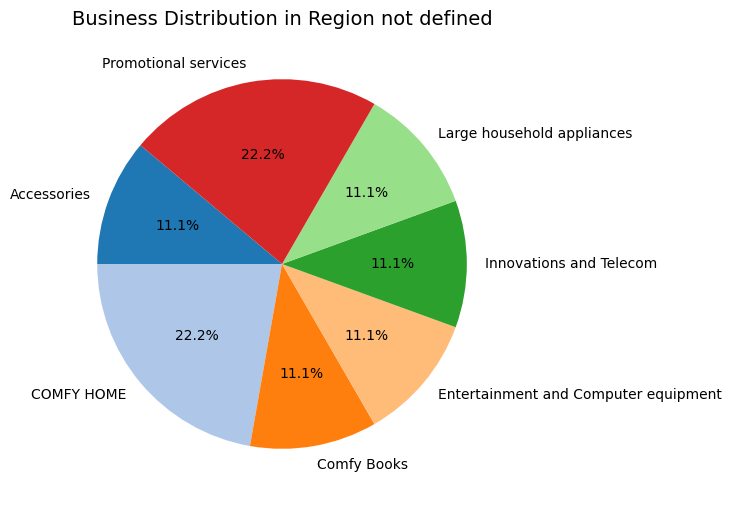

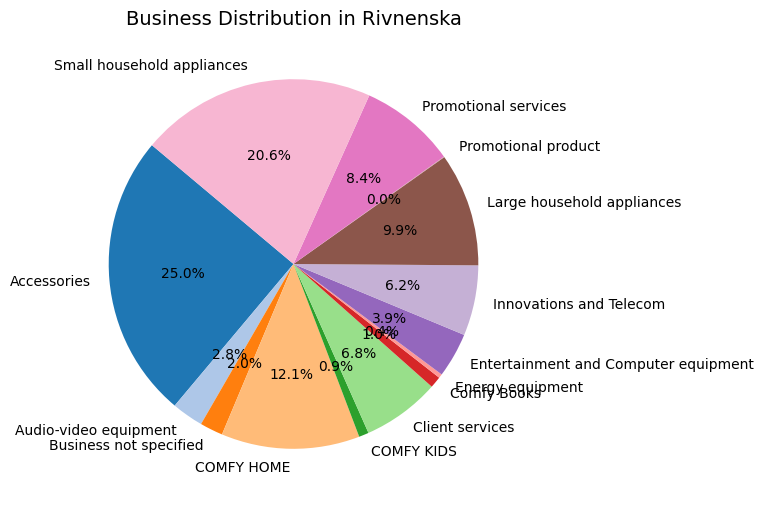

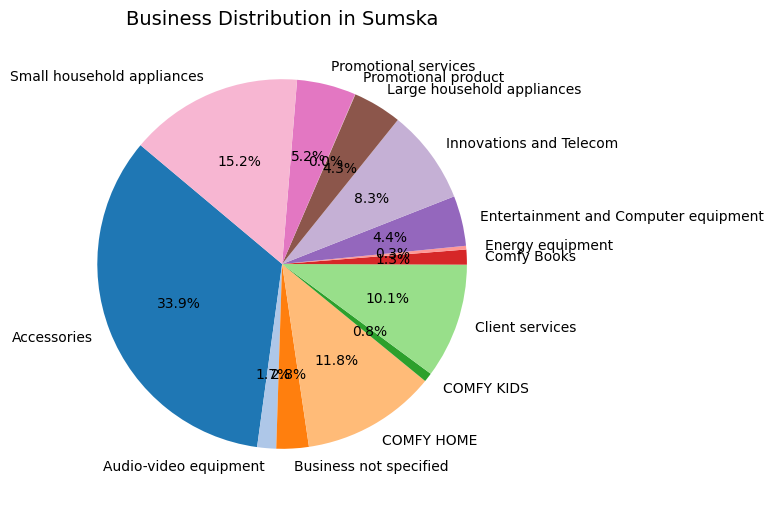

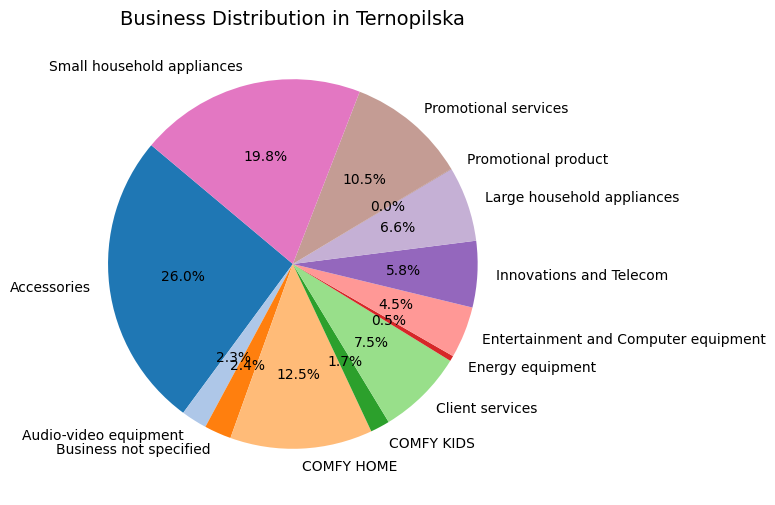

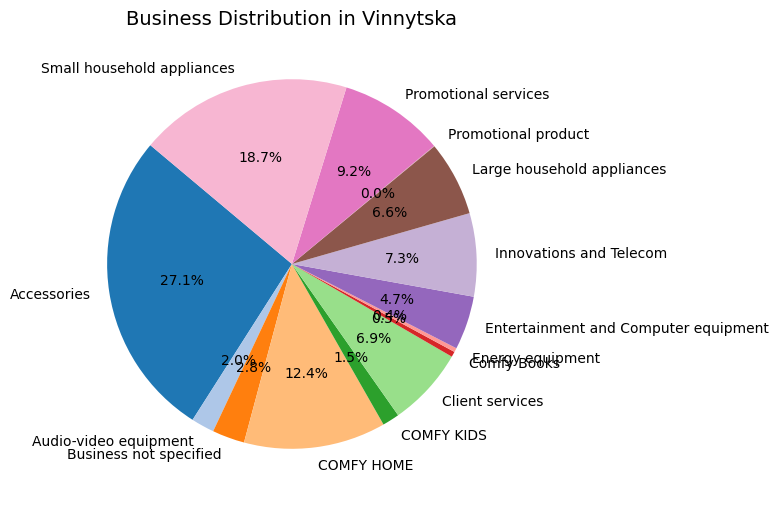

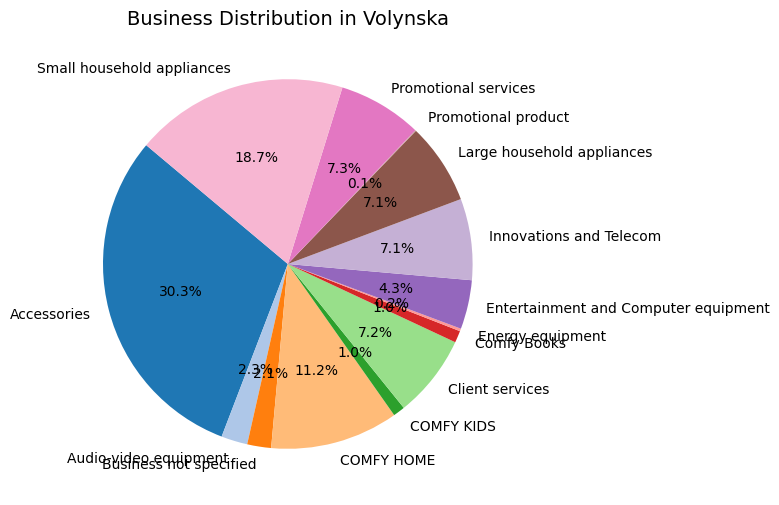

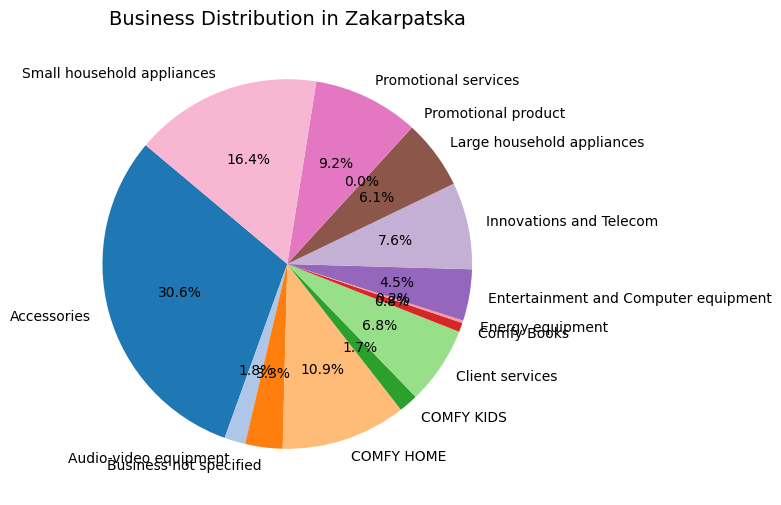

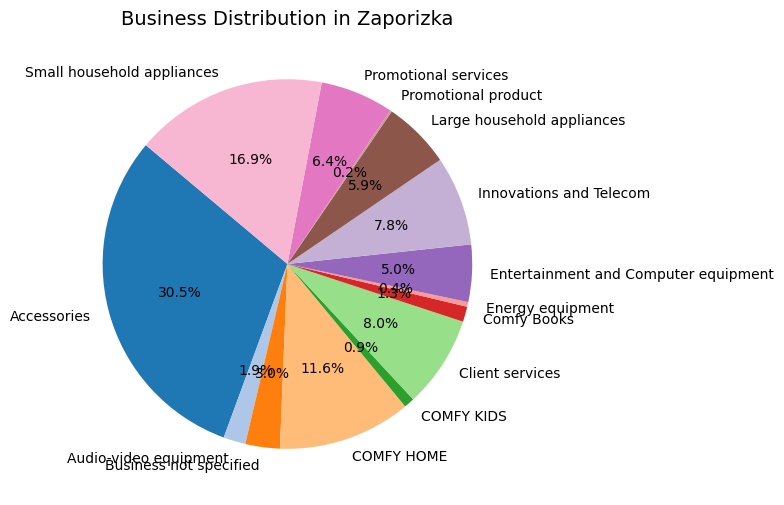

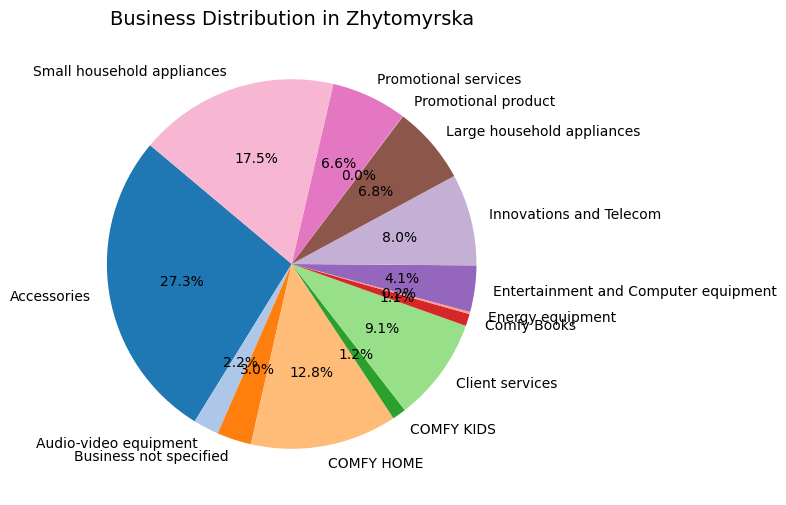

In [71]:
# Group by Region and Business to calculate the count of transactions
region_business_counts = transactions.groupby(['Region', 'Business']).size().reset_index(name='Count')

# Get the list of unique regions
regions = region_business_counts['Region'].unique()

# Create pie charts for each region
for region in regions:
    # Filter data for the current region
    region_data = region_business_counts[region_business_counts['Region'] == region]
    
    # Plot the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(region_data['Count'], labels=region_data['Business'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    
    # Add title
    plt.title(f'Business Distribution in {region}', fontsize=14)
    
    # Show the plot
    plt.show()

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


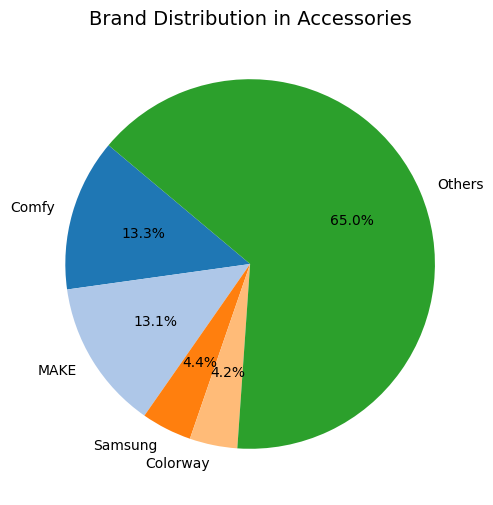

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


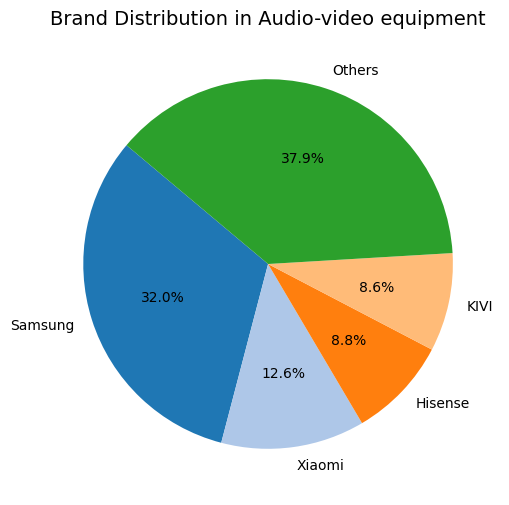

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


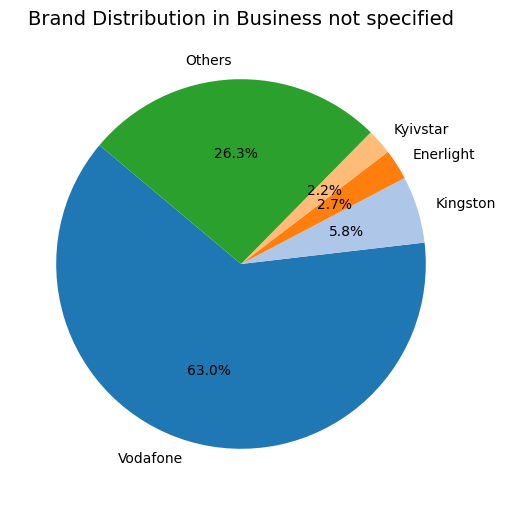

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


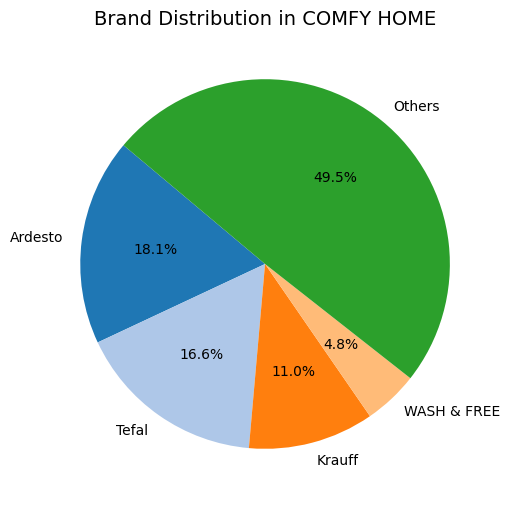

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


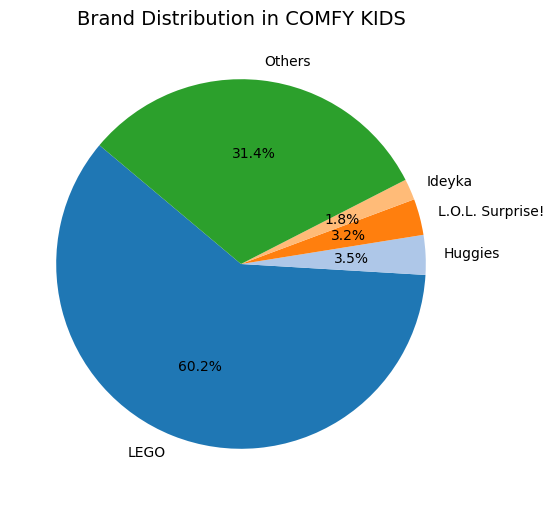

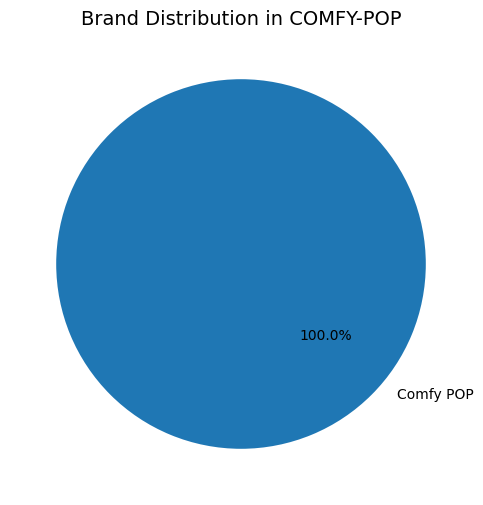

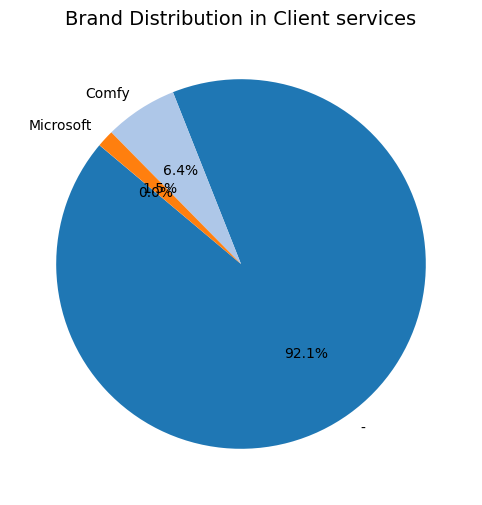

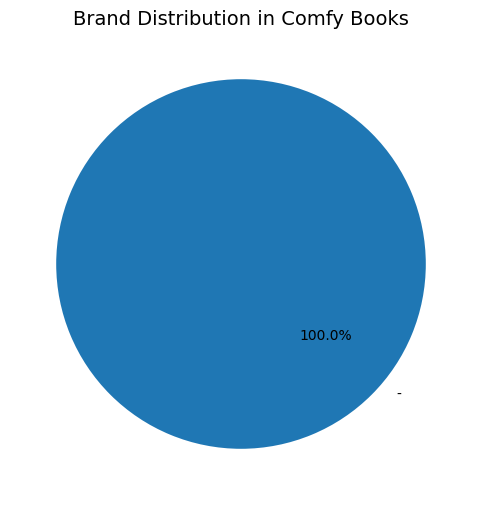

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


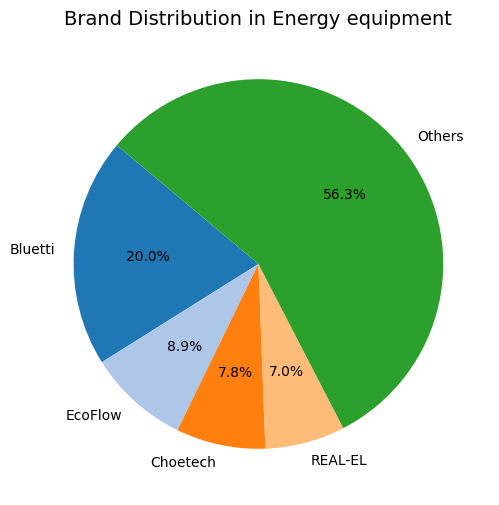

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


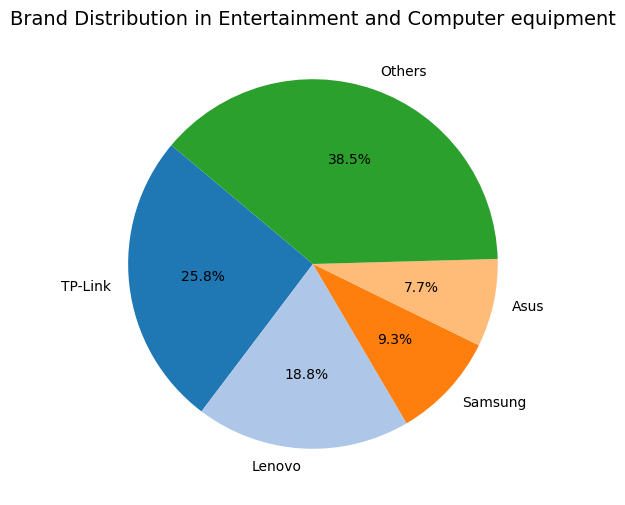

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


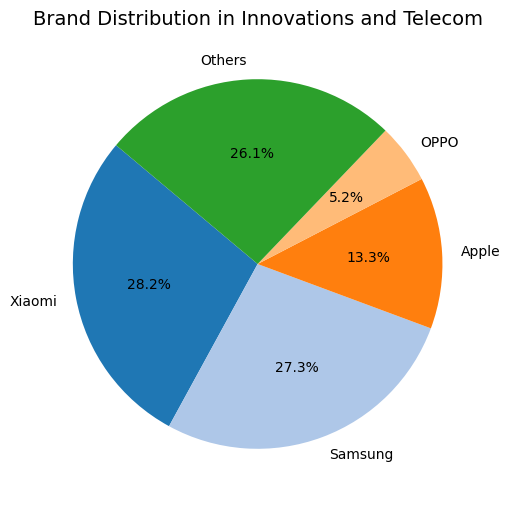

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


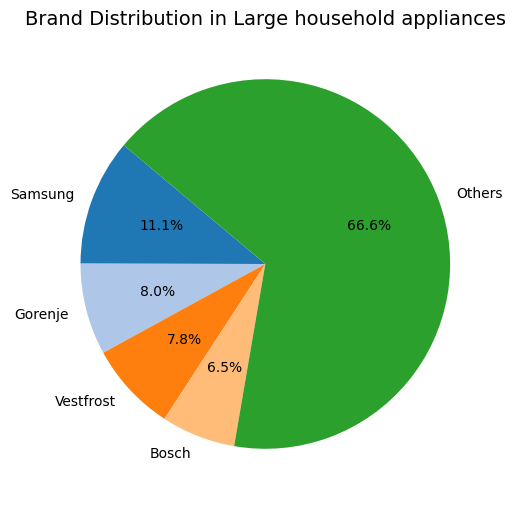

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


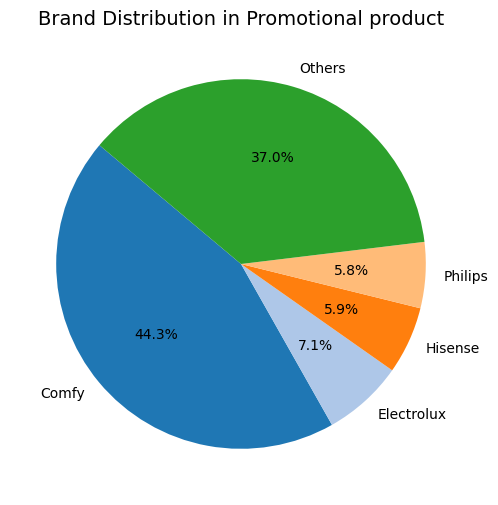

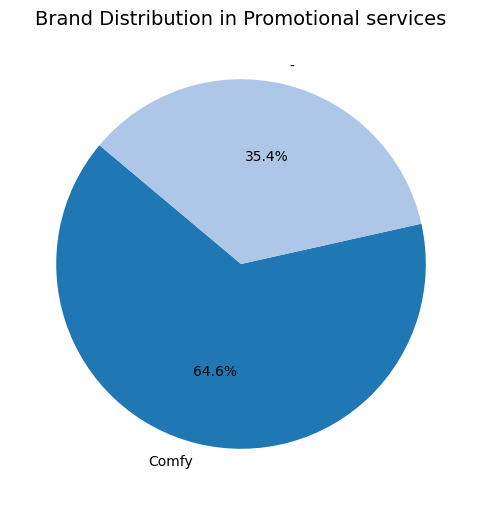

/var/folders/zk/99f_5qyj0zdfnvv_0d74zx140000gn/T/ipykernel_33649/2055887548.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)


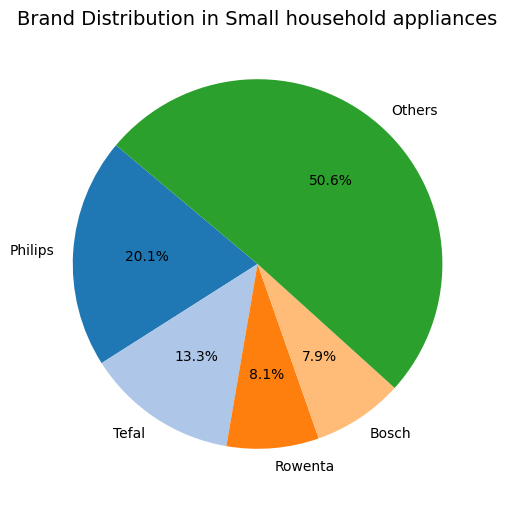

In [73]:
# Group by Business and Brand to calculate the count of transactions
business_brand_counts = transactions.groupby(['Business', 'Brand']).size().reset_index(name='Count')

# Get the list of unique businesses
businesses = business_brand_counts['Business'].unique()

# Create pie charts for each business
for business in businesses:
    # Filter data for the current business
    business_data = business_brand_counts[business_brand_counts['Business'] == business]
    
    # Sort by count and identify top 4 brands
    business_data = business_data.sort_values('Count', ascending=False)
    top_brands = business_data[:4]
    others_count = business_data[4:]['Count'].sum()
    
    # Combine top 4 brands and "Others"
    if others_count > 0:
        top_brands = top_brands.append({'Brand': 'Others', 'Count': others_count}, ignore_index=True)
    
    # Plot the pie chart
    plt.figure(figsize=(8, 6))
    plt.pie(top_brands['Count'], labels=top_brands['Brand'], autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
    
    # Add title
    plt.title(f'Brand Distribution in {business}', fontsize=14)
    
    # Show the plot
    plt.show()

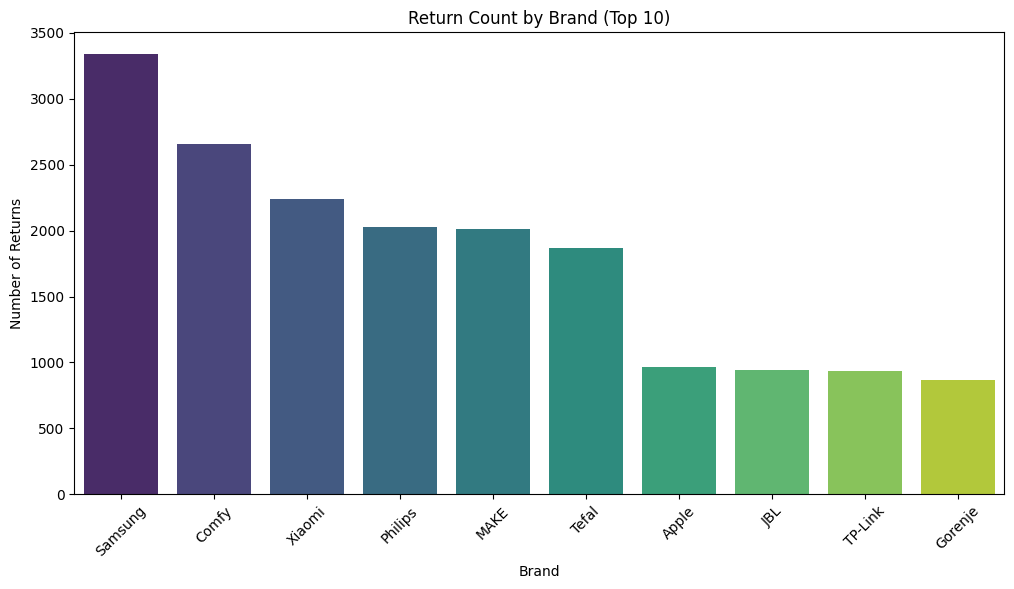

In [31]:
# Filter transactions for returns (Sale_Return == 0) and exclude rows where Brand is "-"
returns = transactions[(transactions['Sale_Return'] == 0) & (transactions['Brand'] != "-")]

# Count returns per brand and sort in descending order
brand_returns = returns.groupby('Brand').size().reset_index(name='Return_Count')
brand_returns = brand_returns.sort_values('Return_Count', ascending=False).head(10)

# Plot bar chart for top 10 brands with highest returns
plt.figure(figsize=(12, 6))
sns.barplot(x='Brand', y='Return_Count', data=brand_returns, palette='viridis')
plt.title('Return Count by Brand (Top 10)')
plt.xlabel('Brand')
plt.ylabel('Number of Returns')
plt.xticks(rotation=45)
plt.show()

In [155]:
loyalty_data['Date'] = pd.to_datetime(loyalty_data['Date'])
loyalty_data['Month'] = loyalty_data['Date'].dt.to_period('M')

# Aggregate revenue by month
monthly_revenue = loyalty_data.groupby('Month')['Revenue'].sum().reset_index()

# Convert 'Month' back to datetime for time series analysis
monthly_revenue['Month'] = monthly_revenue['Month'].dt.to_timestamp()

# Set 'Month' as the index and sort the data.
monthly_revenue = monthly_revenue.set_index('Month').sort_index()

print(monthly_revenue.head())

                Revenue
Month                  
2023-01-01  168592577.0
2023-02-01  163518133.0
2023-03-01  169950518.0
2023-04-01  165495151.0
2023-05-01  189590357.0


In [32]:
# from statsmodels.tsa.arima.model import ARIMA

# # Select the revenue time series
# revenue_ts = monthly_revenue['Revenue']

# # Fit an ARIMA model; note that (1,1,1) is a starting point and may need tuning.
# model = ARIMA(revenue_ts, order=(1, 1, 1))
# model_fit = model.fit()

# # Forecast the next 12 months
# forecast_steps = 12
# forecast = model_fit.get_forecast(steps=forecast_steps)
# forecast_ci = forecast.conf_int()

# # Create index for forecasted periods
# forecast_index = pd.date_range(start=revenue_ts.index[-1] + pd.DateOffset(months=1), 
#                                periods=forecast_steps, freq='MS')
# forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

# # Plot the historical revenue along with the forecast and its confidence intervals
# plt.figure(figsize=(10, 6))
# plt.plot(revenue_ts, label='Historical Revenue')
# plt.plot(forecast_series, label='Forecast', color='red')
# plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
#                  color='pink', alpha=0.3, label='Confidence Interval')
# plt.title('Revenue Forecast using ARIMA')
# plt.xlabel('Date')
# plt.ylabel('Revenue')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [38]:
transaction_cleaned = pd.read_csv('Comfy_Data/transactions_without_fully_returned_purchases.csv')

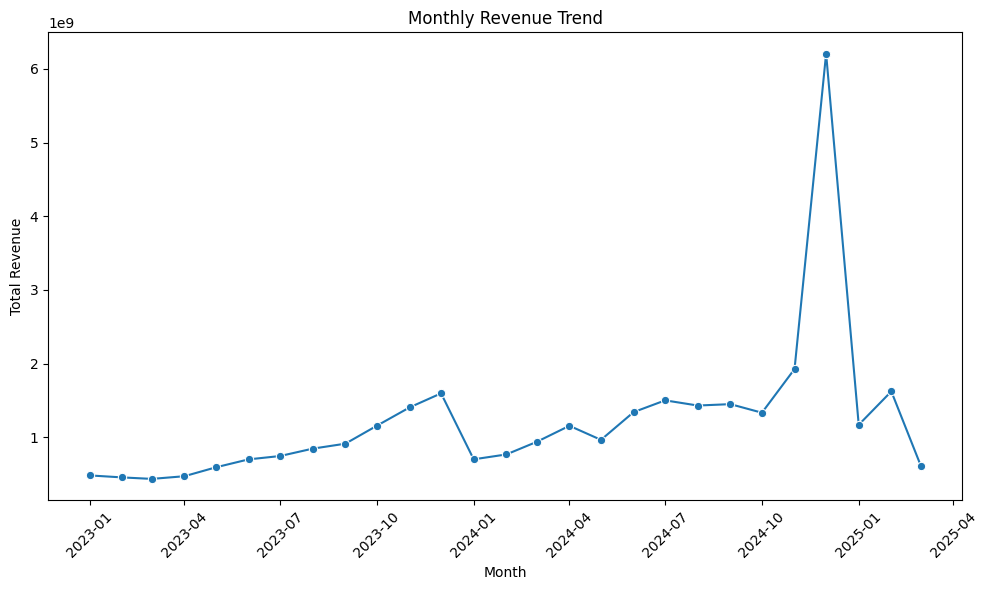

In [39]:
transaction_cleaned['Date'] = pd.to_datetime(transaction_cleaned['Date'], errors='coerce')

# Create a Month column for aggregation; assuming transactions has Date and Revenue
transaction_cleaned['Month'] = transaction_cleaned['Date'].dt.to_period('M')

# Aggregate revenue by month
monthly_revenue = transaction_cleaned.groupby('Month')['Revenue'].sum().reset_index()
monthly_revenue['Month'] = monthly_revenue['Month'].dt.to_timestamp()

# Plotting Monthly Revenue Trend
plt.figure(figsize=(10,6))
sns.lineplot(data=monthly_revenue, x='Month', y='Revenue', marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

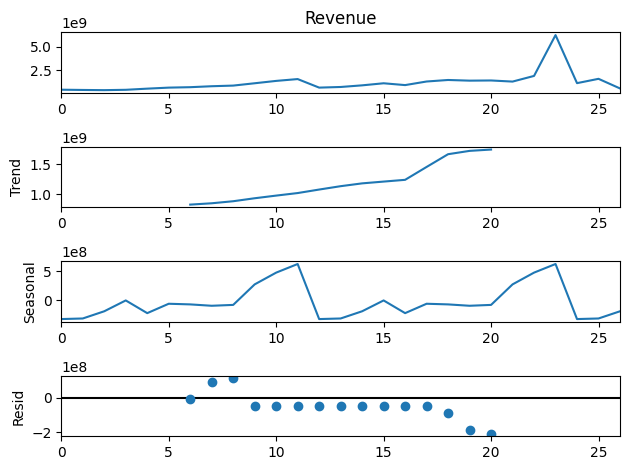

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(monthly_revenue['Revenue'], model='additive', period=12)
decomposition.plot()
plt.tight_layout()
plt.show()

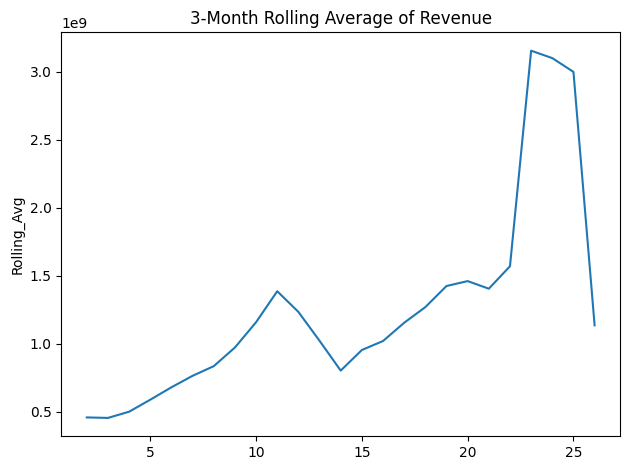

In [41]:
monthly_revenue['Rolling_Avg'] = monthly_revenue['Revenue'].rolling(window=3).mean()
sns.lineplot(data=monthly_revenue, x=monthly_revenue.index, y='Rolling_Avg')
plt.title('3-Month Rolling Average of Revenue')
plt.tight_layout()
plt.show()

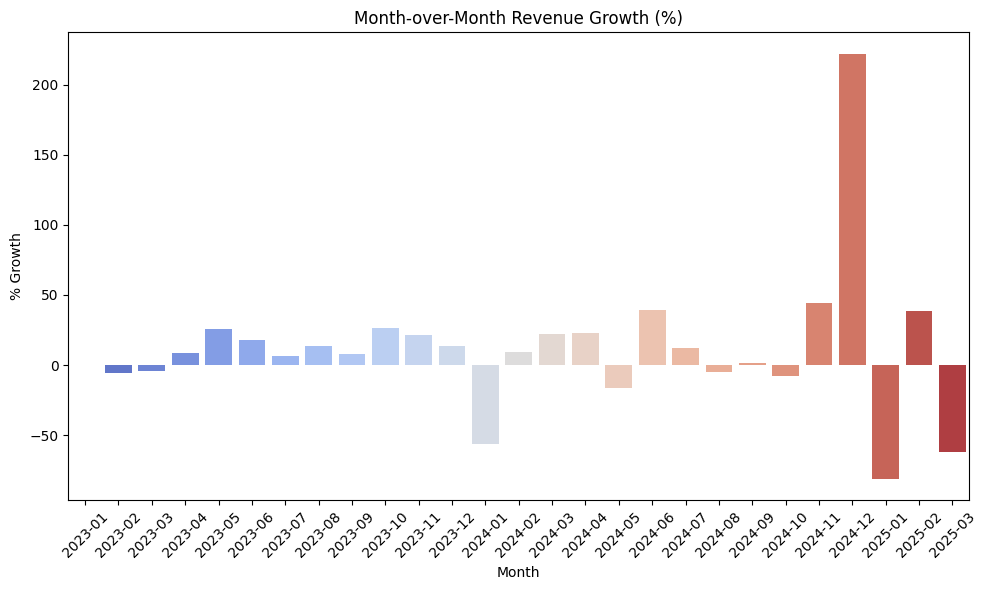

In [153]:
monthly_revenue['MoM_Growth'] = monthly_revenue['Revenue'].pct_change() * 100

plt.figure(figsize=(10,6))
sns.barplot(x=monthly_revenue['Month'].dt.strftime('%Y-%m'), y=monthly_revenue['MoM_Growth'], palette='coolwarm')
plt.title('Month-over-Month Revenue Growth (%)')
plt.xlabel('Month')
plt.ylabel('% Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

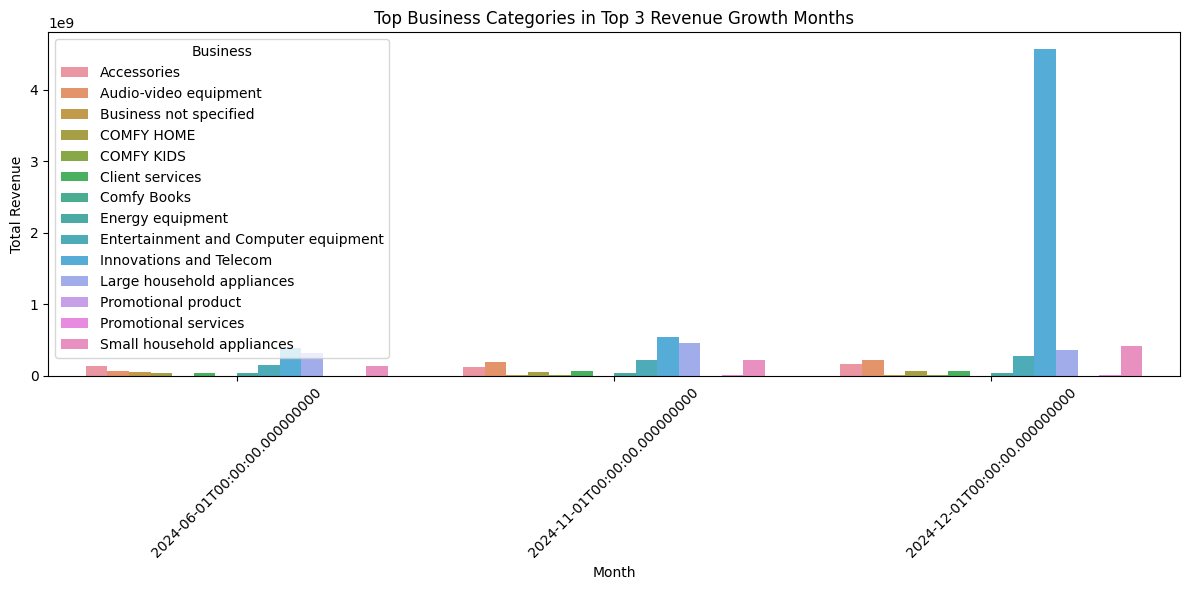

In [154]:
# Step 1: Top 3 growth months
top_3_growth_months = monthly_revenue.sort_values(by='MoM_Growth', ascending=False).head(3)['Month']

# Step 2: Filter data
transaction_cleaned['Month'] = transaction_cleaned['Date'].dt.to_period('M').dt.to_timestamp()
top_growth_data = transaction_cleaned[transaction_cleaned['Month'].isin(top_3_growth_months)]

# Step 3: Group and clean
top_growth_grouped = top_growth_data.groupby(['Month', 'Business'])['Revenue'].sum().reset_index()
top_growth_grouped = top_growth_grouped.dropna(subset=['Business', 'Revenue'])
top_growth_grouped['Business'] = top_growth_grouped['Business'].astype(str)

# Step 4: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_growth_grouped, x='Month', y='Revenue', hue='Business')
plt.title('Top Business Categories in Top 3 Revenue Growth Months')
plt.ylabel('Total Revenue')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

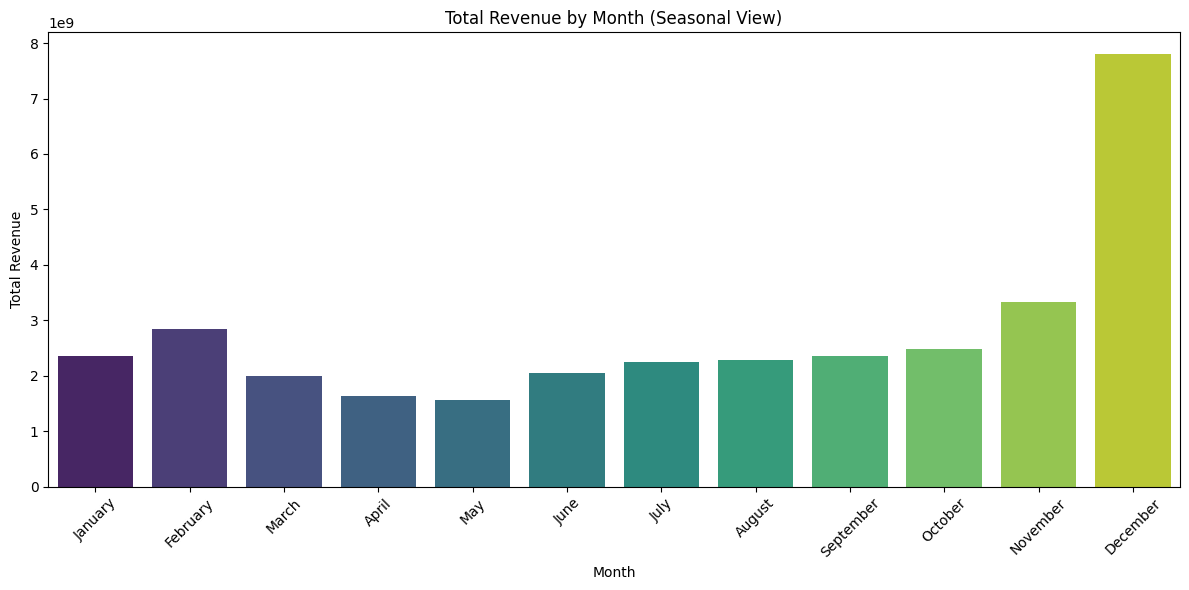

In [155]:
transaction_cleaned['Month_Name'] = transaction_cleaned['Date'].dt.month_name()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_rev_by_name = transaction_cleaned.groupby('Month_Name')['Revenue'].sum().reindex(month_order)

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_rev_by_name.index, y=monthly_rev_by_name.values, palette='viridis')
plt.title('Total Revenue by Month (Seasonal View)')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

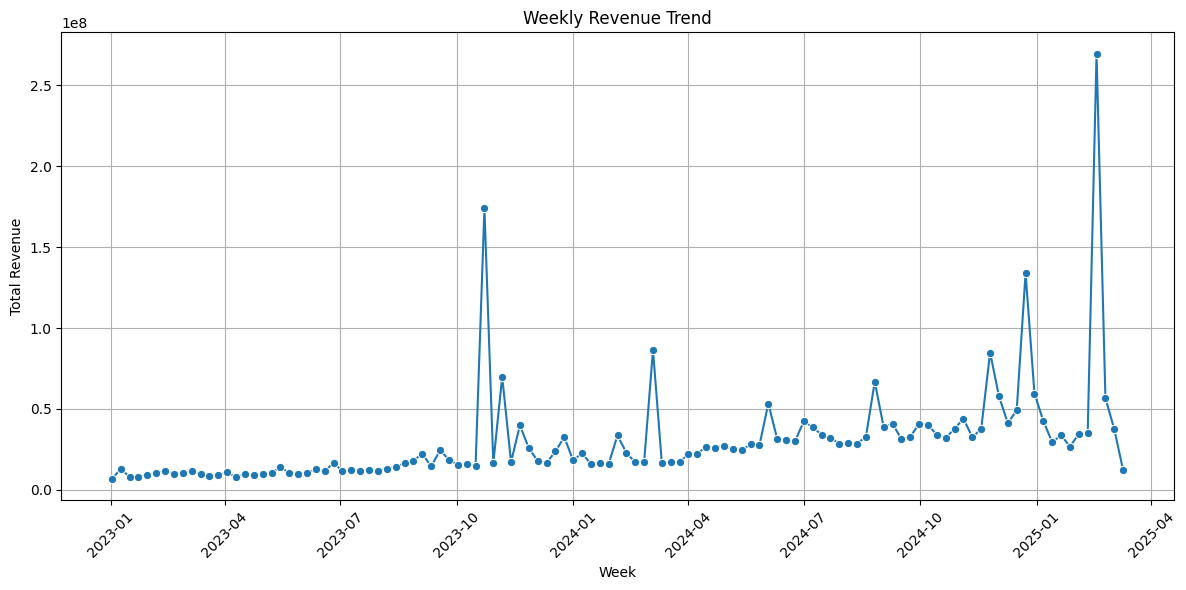

In [143]:
# Extract week start date
loyalty_data['Week'] = loyalty_data['Date'].dt.to_period('W').dt.start_time

# Group by week and sum revenue
weekly_revenue = loyalty_data.groupby('Week')['Revenue'].sum().reset_index()

# Plot weekly revenue trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=weekly_revenue, x='Week', y='Revenue', marker='o')
plt.title('Weekly Revenue Trend')
plt.xlabel('Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

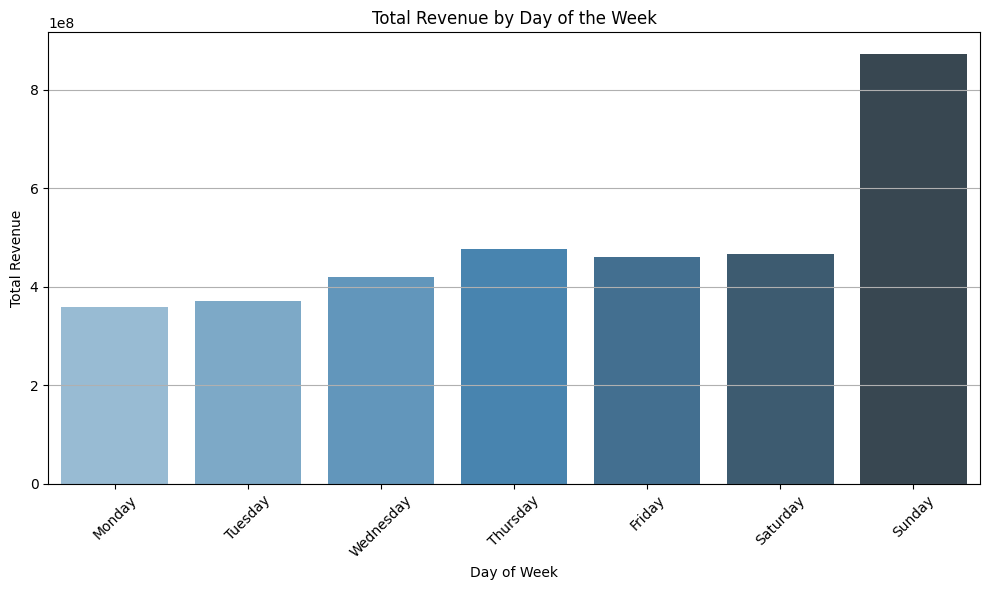

In [144]:
loyalty_data['DayOfWeek'] = loyalty_data['Date'].dt.day_name()
daily_pattern = loyalty_data.groupby('DayOfWeek')['Revenue'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

# Plotting total revenue by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values, palette='Blues_d')

plt.title('Total Revenue by Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

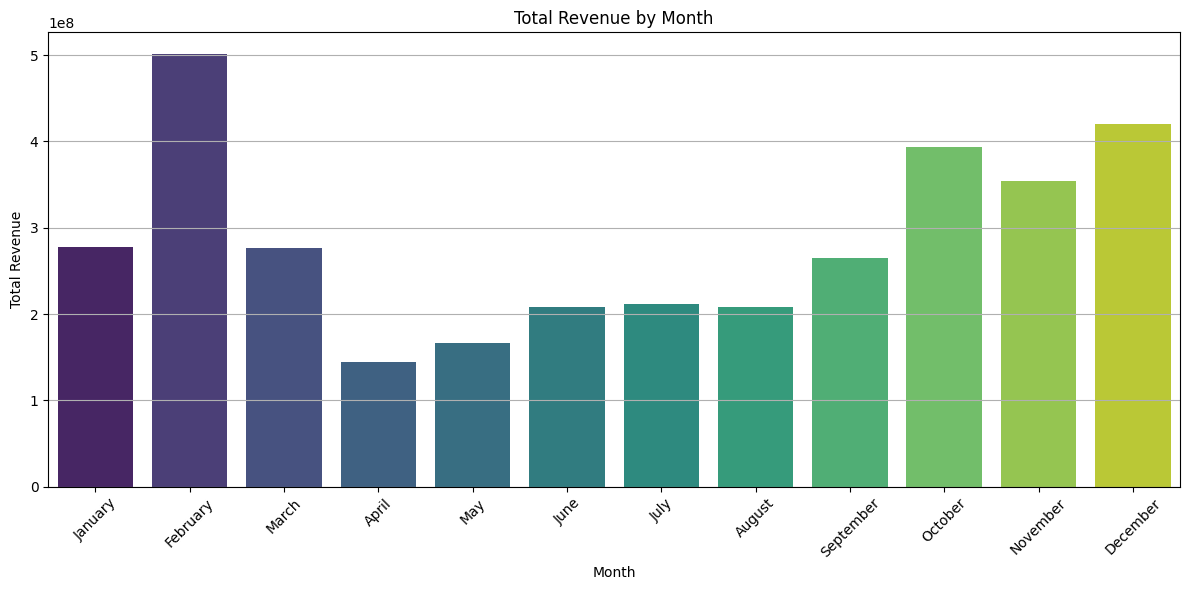

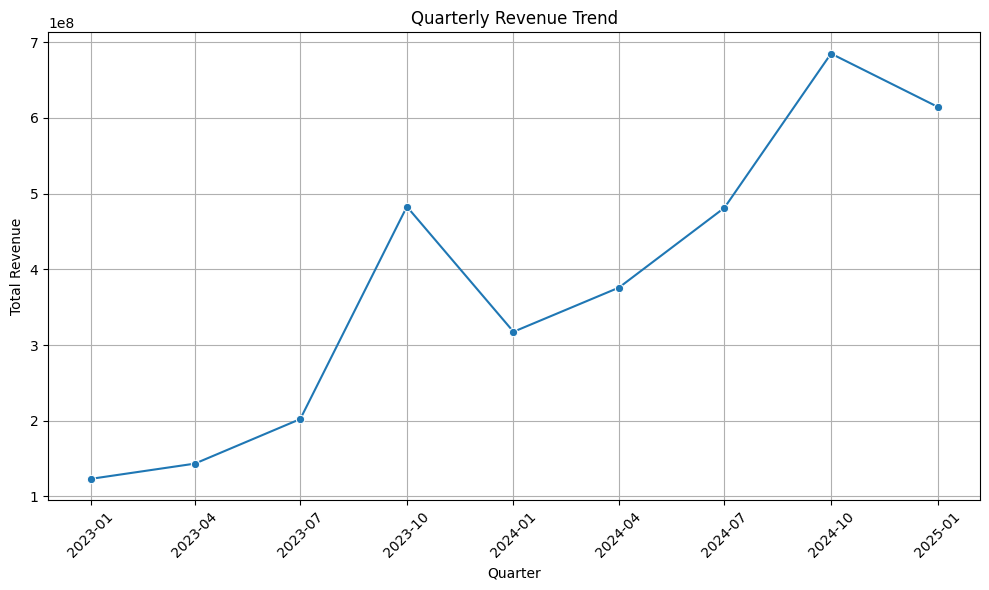

In [146]:
loyalty_data['Month_Name'] = loyalty_data['Date'].dt.month_name()
loyalty_data['Quarter'] = loyalty_data['Date'].dt.to_period('Q')

# Aggregate revenue by month name (calendar-wise)
monthly_rev_by_name = loyalty_data.groupby('Month_Name')['Revenue'].sum()

# To display months in order (not alphabetically), use a categorical type
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_rev_by_name = monthly_rev_by_name.reindex(month_order)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_rev_by_name.index, y=monthly_rev_by_name.values, palette="viridis")
plt.title('Total Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# Convert quarter period to timestamp for plotting
loyalty_data['Quarter'] = loyalty_data['Quarter'].dt.to_timestamp()

# Aggregate revenue by quarter
quarterly_revenue = loyalty_data.groupby('Quarter')['Revenue'].sum().reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=quarterly_revenue, x='Quarter', y='Revenue', marker='o')
plt.title('Quarterly Revenue Trend')
plt.xlabel('Quarter')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()